# Credit Card Fraud Detection

## Problem Statement

Fraudulent activities have increased severalfold, with around 52,304 cases of credit/debit card fraud reported in FY'19 alone. Due to this steep increase in banking frauds, it is the need of the hour to detect these fraudulent transactions in time in order to help consumers as well as banks, who are losing their credit worth each day. Every fraudulent credit card transaction that occur is a direct financial loss to the bank as the bank is responsible for the fraud transactions as well it also affects the overall customer satisfaction adversely.


## Data Source: https://www.kaggle.com/mlg-ulb/creditcardfraud

The data set that you will be working on during this project was obtained from Kaggle. It contains thousands of individual transactions that took place over a course of two days and their respective labels.

As you saw, the data set includes credit card transactions made by European cardholders over a period of two days in September 2013. Out of a total of 2,84,807 transactions, 492 were fraudulent. This data set is highly unbalanced, with the positive class (frauds) accounting for just 0.172% of the total transactions. The data set has also been modified with Principal Component Analysis (PCA) to maintain confidentiality. Apart from ‘time’ and ‘amount’, all the other features (V1, V2, V3, up to V28) are the principal components obtained using PCA. The feature 'time' contains the seconds elapsed between the first transaction in the data set and the subsequent transactions. The feature 'amount' is the transaction amount. The feature 'class' represents class labelling, and it takes the value 1 in cases of fraud and 0 in others.

The distribution plots of the variables were Gaussian, which might indicate the effects of transformations that had already occurred on the data set. 

In [71]:
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

import sklearn
from sklearn import metrics
from sklearn.metrics import roc_curve, auc 
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import average_precision_score, precision_recall_curve

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, PowerTransformer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import Ridge, Lasso, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
# Import:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

#install scikit-optimize
!pip install scikit-optimize
from skopt import BayesSearchCV


# To ignore warnings
import warnings
warnings.filterwarnings("ignore")

## Exploratory data analysis

In [3]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
#observe the different feature type present in the data
# Check for shape (i.e. row and number of columns)
df.shape

(284807, 31)

In [5]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,...,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [6]:
# Check for non-nullable and nullable columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

### Here we will observe the distribution of our classes

In [8]:
classes=df['Class'].value_counts()
normal_share=classes[0]/df['Class'].count()*100
fraud_share=classes[1]/df['Class'].count()*100

print('----- Classes -----')
print(classes)
print('\n----- Normal share -----')
print(normal_share)
print('\n----- Fraud share -----')
print(fraud_share)

----- Classes -----
0    284315
1       492
Name: Class, dtype: int64

----- Normal share -----
99.82725143693798

----- Fraud share -----
0.1727485630620034


In [9]:
# correlation matrix
cor = df.corr()
cor

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Time,1.000000,1.173963e-01,-1.059333e-02,-4.196182e-01,-1.052602e-01,1.730721e-01,-6.301647e-02,8.471437e-02,-3.694943e-02,-8.660434e-03,...,4.473573e-02,1.440591e-01,5.114236e-02,-1.618187e-02,-2.330828e-01,-4.140710e-02,-5.134591e-03,-9.412688e-03,-0.010596,-0.012323
V1,0.117396,1.000000e+00,4.135835e-16,-1.227819e-15,-9.215150e-16,1.812612e-17,-6.506567e-16,-1.005191e-15,-2.433822e-16,-1.513678e-16,...,-2.457409e-16,-4.290944e-16,6.168652e-16,-4.425156e-17,-9.605737e-16,-1.581290e-17,1.198124e-16,2.083082e-15,-0.227709,-0.101347
V2,-0.010593,4.135835e-16,1.000000e+00,3.243764e-16,-1.121065e-15,5.157519e-16,2.787346e-16,2.055934e-16,-5.377041e-17,1.978488e-17,...,-8.480447e-17,1.526333e-16,1.634231e-16,1.247925e-17,-4.478846e-16,2.057310e-16,-4.966953e-16,-5.093836e-16,-0.531409,0.091289
V3,-0.419618,-1.227819e-15,3.243764e-16,1.000000e+00,4.711293e-16,-6.539009e-17,1.627627e-15,4.895305e-16,-1.268779e-15,5.568367e-16,...,5.706192e-17,-1.133902e-15,-4.983035e-16,2.686834e-19,-1.104734e-15,-1.238062e-16,1.045747e-15,9.775546e-16,-0.210880,-0.192961
V4,-0.105260,-9.215150e-16,-1.121065e-15,4.711293e-16,1.000000e+00,-1.719944e-15,-7.491959e-16,-4.104503e-16,5.697192e-16,6.923247e-16,...,-1.949553e-16,-6.276051e-17,9.164206e-17,1.584638e-16,6.070716e-16,-4.247268e-16,3.977061e-17,-2.761403e-18,0.098732,0.133447
V5,0.173072,1.812612e-17,5.157519e-16,-6.539009e-17,-1.719944e-15,1.000000e+00,2.408382e-16,2.715541e-16,7.437229e-16,7.391702e-16,...,-3.920976e-16,1.253751e-16,-8.428683e-18,-1.149255e-15,4.808532e-16,4.319541e-16,6.590482e-16,-5.613951e-18,-0.386356,-0.094974
V6,-0.063016,-6.506567e-16,2.787346e-16,1.627627e-15,-7.491959e-16,2.408382e-16,1.000000e+00,1.191668e-16,-1.104219e-16,4.131207e-16,...,5.833316e-17,-4.705235e-19,1.046712e-16,-1.071589e-15,4.562861e-16,-1.357067e-16,-4.452461e-16,2.594754e-16,0.215981,-0.043643
V7,0.084714,-1.005191e-15,2.055934e-16,4.895305e-16,-4.104503e-16,2.715541e-16,1.191668e-16,1.000000e+00,3.344412e-16,1.122501e-15,...,-2.027779e-16,-8.898922e-16,-4.387401e-16,7.434913e-18,-3.094082e-16,-9.657637e-16,-1.782106e-15,-2.776530e-16,0.397311,-0.187257
V8,-0.036949,-2.433822e-16,-5.377041e-17,-1.268779e-15,5.697192e-16,7.437229e-16,-1.104219e-16,3.344412e-16,1.000000e+00,4.356078e-16,...,3.892798e-16,2.026927e-16,6.377260e-17,-1.047097e-16,-4.653279e-16,-1.727276e-16,1.299943e-16,-6.200930e-16,-0.103079,0.019875
V9,-0.008660,-1.513678e-16,1.978488e-17,5.568367e-16,6.923247e-16,7.391702e-16,4.131207e-16,1.122501e-15,4.356078e-16,1.000000e+00,...,1.936953e-16,-7.071869e-16,-5.214137e-16,-1.430343e-16,6.757763e-16,-7.888853e-16,-6.709655e-17,1.110541e-15,-0.044246,-0.097733


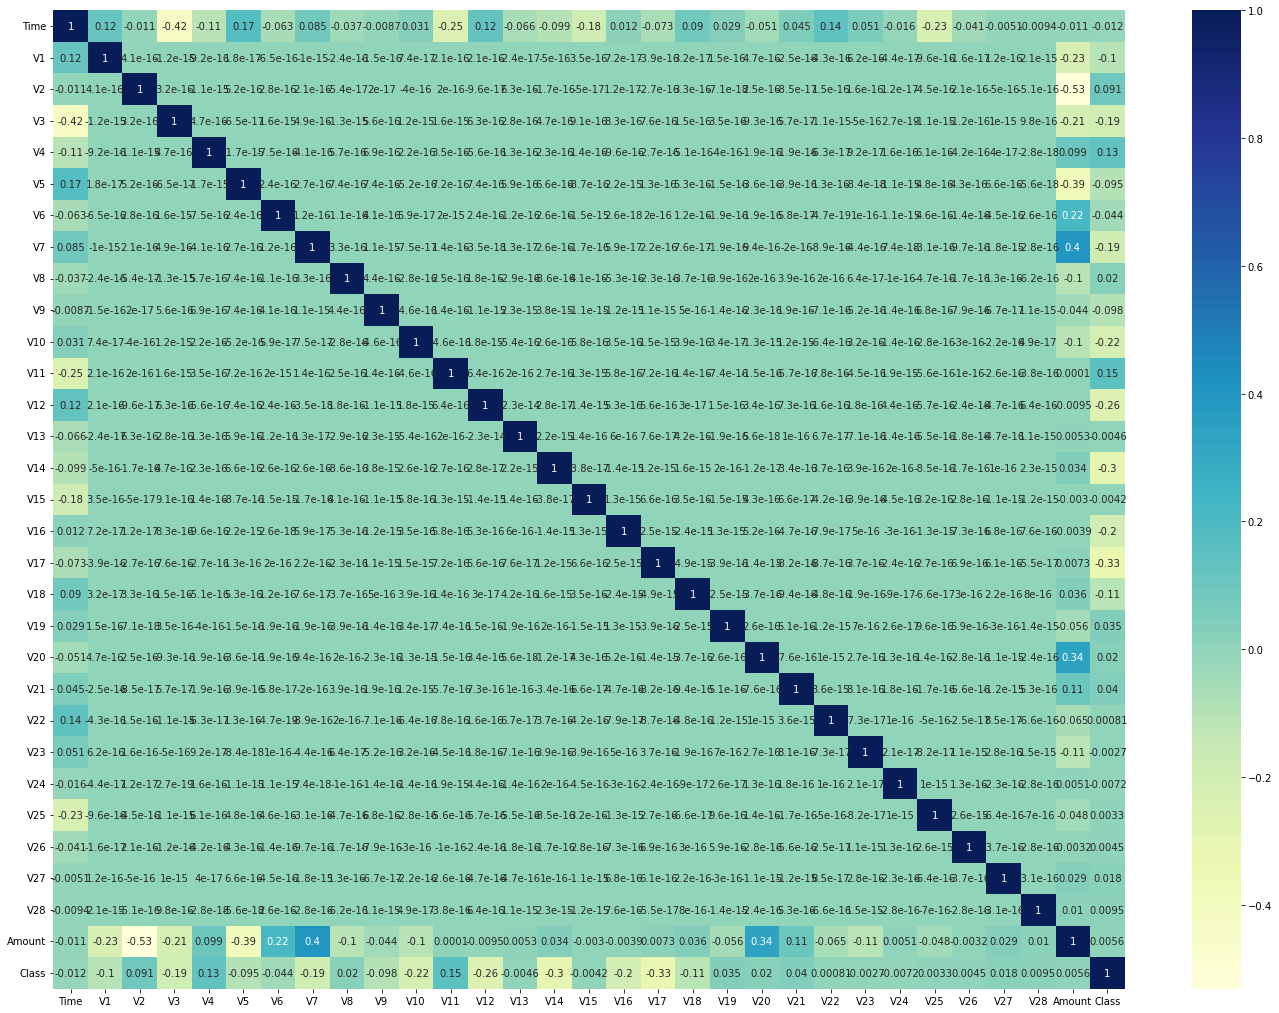

In [10]:
# correlations on a heatmap
plt.figure(figsize=(24,18))
sns.heatmap(cor, cmap="YlGnBu", annot=True)
plt.show()

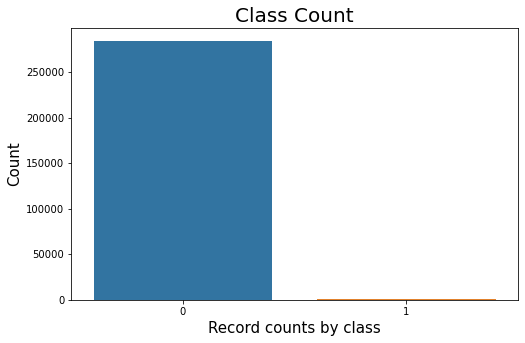

In [12]:
# Create a bar plot for the number and percentage of fraudulent vs non-fraudulent transcations
plt.figure(figsize=(8,5))
sns.countplot(df['Class'])
plt.title("Class Count", fontsize=20)
plt.xlabel("Record counts by class", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.show()

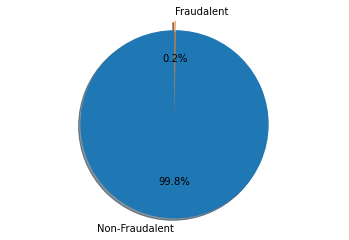

In [13]:
# ratio in terms of percentage
labels = 'Non-Fraudalent', 'Fraudalent'
sizes = [normal_share, fraud_share]
explode = (0, 0.1) 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.show()

### Observation:
- Approximately 99.8% of the data is non-fradultent
- Approximately 0.2% of the data is fradulent ( i.e. 492 out of 284807 credit card transactions)

In [14]:
# Create a scatter plot to observe the distribution of classes with time
Delta_Time = pd.to_timedelta(df['Time'], unit='s')
#Create derived columns Mins and hours
df['Time_Day'] = (Delta_Time.dt.components.days).astype(int)
df['Time_Hour'] = (Delta_Time.dt.components.hours).astype(int)
df['Time_Min'] = (Delta_Time.dt.components.minutes).astype(int)

Text(0.5, 1.05, 'Time vs Class Distribution')

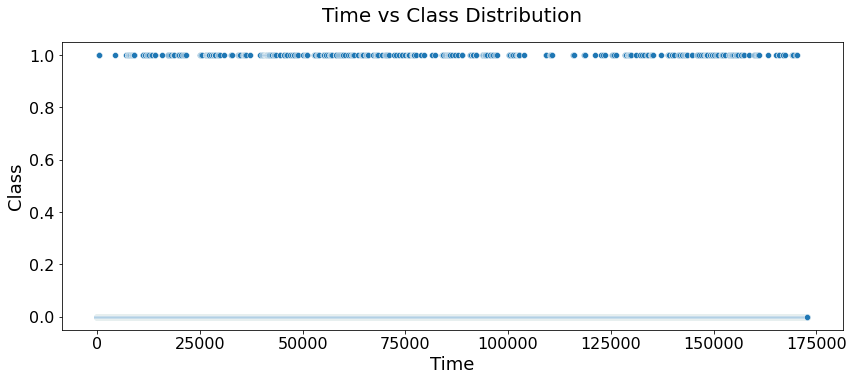

In [16]:
fig = plt.figure(figsize=(14, 18))
cmap = sns.color_palette('Set2')
plt.subplot(3,1,1)
sns.scatterplot(x=df['Time'], y='Class', palette=cmap, data=df)
plt.xlabel('Time', size=18)
plt.ylabel('Class', size=18)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16) 
plt.title('Time vs Class Distribution', size=20, y=1.05)

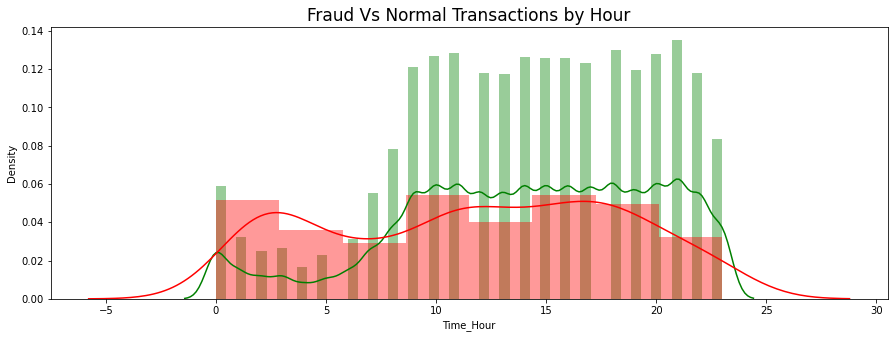

In [17]:
#The fraud Vs normal trasaction by hour
plt.figure(figsize=(15,5))
sns.distplot(df[df['Class'] == 0]["Time_Hour"], color='green')
sns.distplot(df[df['Class'] == 1]["Time_Hour"], color='red')
plt.title('Fraud Vs Normal Transactions by Hour', fontsize=17)
plt.show()

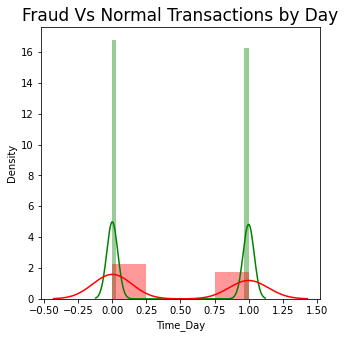

In [18]:
#The fraud Vs normal trasaction by day
plt.figure(figsize=(5,5))
sns.distplot(df[df['Class'] == 0]["Time_Day"], color='green')
sns.distplot(df[df['Class'] == 1]["Time_Day"], color='red')
plt.title('Fraud Vs Normal Transactions by Day', fontsize=17)
plt.show()

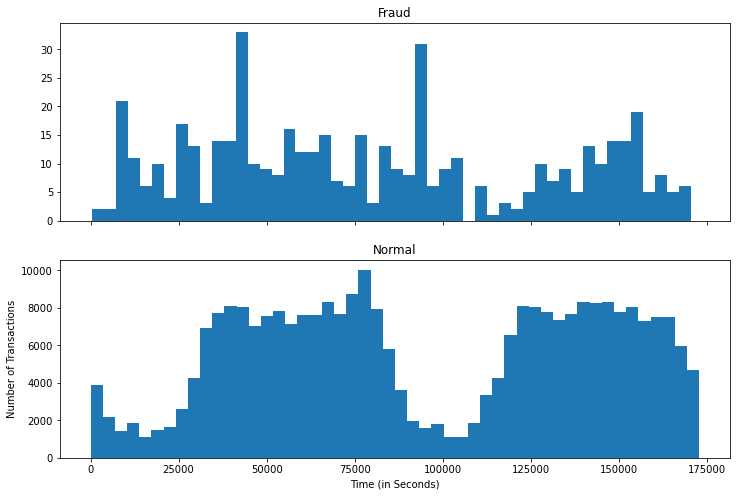

In [21]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,8))

bins = 50
ax1.hist(df.Time[df.Class == 1], bins = bins)
ax1.set_title('Fraud')

ax2.hist(df.Time[df.Class == 0], bins = bins)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Number of Transactions')
plt.show()

In [23]:
# Create a scatter plot to observe the distribution of classes with Amount
df_Fraud = df[df['Class'] == 1]
df_Regular = df[df['Class'] == 0]

# Fraud Transaction Amount Statistics
print('------ Fraud transaction amount statistics ------')
print(df_Fraud["Amount"].describe())

print('\n------ Regular transaction amount statistics ------')
print(df_Regular["Amount"].describe())

------ Fraud transaction amount statistics ------
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

------ Regular transaction amount statistics ------
count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64


Text(0.5, 1.05, 'Amount vs Class Distribution')

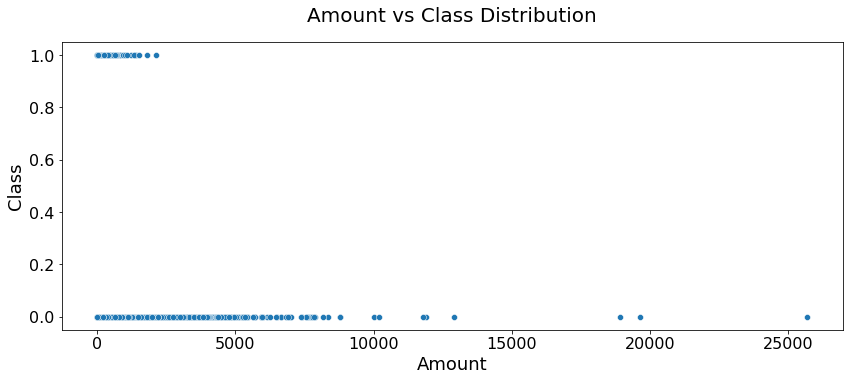

In [24]:
# Amount vs class distribution
fig = plt.figure(figsize=(14, 18))
cmap = sns.color_palette('Set1')

# PLot the relation between the variables:
plt.subplot(3,1,1)
sns.scatterplot(x=df['Amount'], y='Class', palette=cmap, data=df)
plt.xlabel('Amount', size=18)
plt.ylabel('Class', size=18)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16) 
plt.title('Amount vs Class Distribution', size=20, y=1.05)

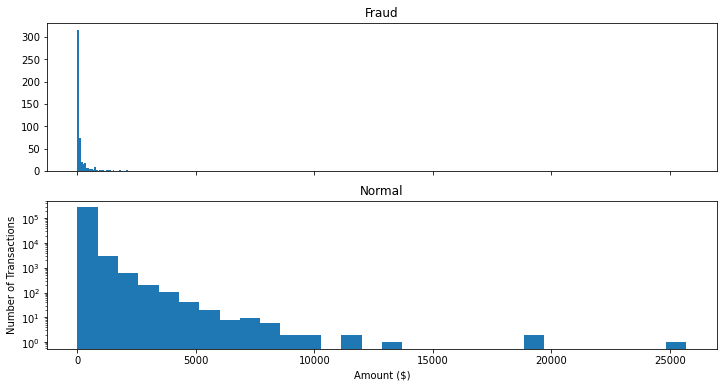

In [27]:
# Fraud vs Normal amount distribution
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,6))

bins = 30

ax1.hist(df.Amount[df.Class == 1], bins = bins)
ax1.set_title('Fraud')

ax2.hist(df.Amount[df.Class == 0], bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.show()

### Check for co-relation between variables to understand their relationship and sort the values in descending order

In [30]:
print("Most important features relative to target variable Class")

corr_initial = df.corr()['Class']
corr_initial = pd.DataFrame(corr_initial)

# correct column label from SalePrice to correlation
corr_initial.columns = ["Correlation"]
corr_initial2 = corr_initial.sort_values(by=['Correlation'], ascending=False)
corr_initial2.head(10)

Most important features relative to target variable Class


,Correlation
Class,1.000000
V11,0.154876
V4,0.133447
V2,0.091289
V21,0.040413
V19,0.034783
V20,0.020090
V8,0.019875
V27,0.017580
V28,0.009536


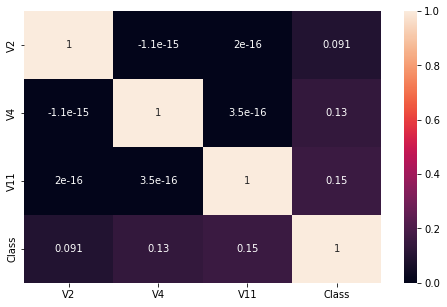

In [33]:
# Check for correlation between variables where class > 0.09
top_feature = cor.index[abs(cor['Class'] > 0.09)]
plt.subplots(figsize=(8, 5))
top_corr = df[top_feature].corr()
sns.heatmap(top_corr, annot=True)
plt.show()

## Boxplot to understand the distribution of numercial attributes

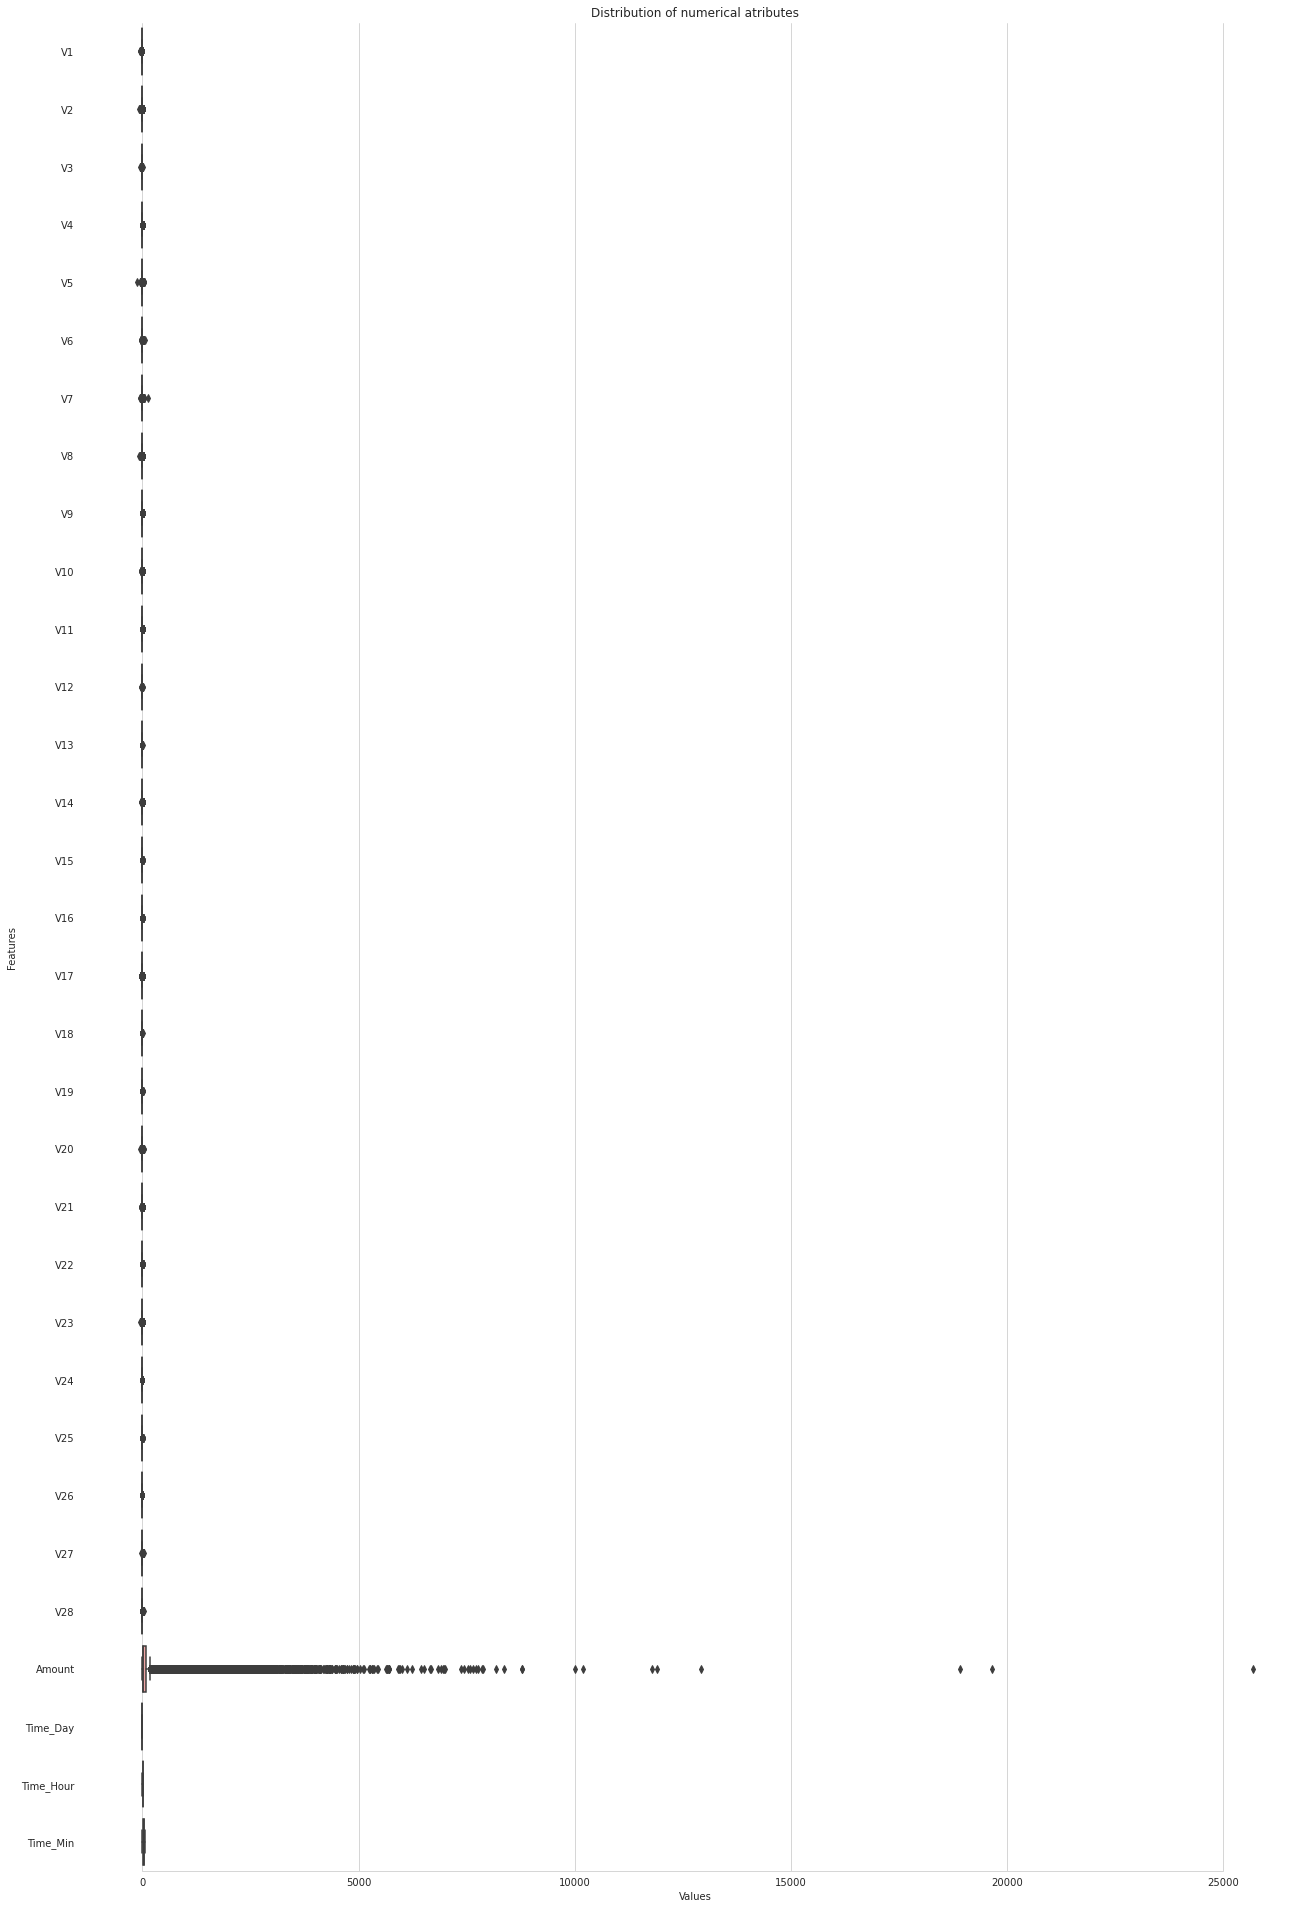

In [36]:
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()

# Excluding BINARY target feature and Time variable as its not needed for transformation : 
li_not_plot = ['Class','Time']
li_transform_num_feats = [c for c in list(numeric_features) if c not in li_not_plot]

sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(22,34))

ax = sns.boxplot(data=df[li_transform_num_feats] , orient="h", palette="Paired")
ax.set(ylabel="Features")
ax.set(xlabel="Values")
ax.set(title="Distribution of numerical atributes")
sns.despine(trim=True,left=True)

# Drop unnecessary columns
### Time column was further divided into hour, day, min. Lets drop the columns Time, hour, min

In [37]:
df.drop(['Time_Day', 'Time_Min', 'Time'], axis = 1, inplace= True)

### Splitting the data into train & test data

In [38]:
# Create X & Y dataset
X = df.drop(['Class'], axis=1)
y = df['Class']

In [39]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20)

##### Preserve X_test & y_test to evaluate on the test data once you build the model

In [40]:
print(np.sum(y))
print(np.sum(y_train))
print(np.sum(y_test))

492
394
98


### Plotting the distribution of a variable

In [42]:
cols = list(X.columns.values)
cols

['V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'Amount',
 'Time_Hour']

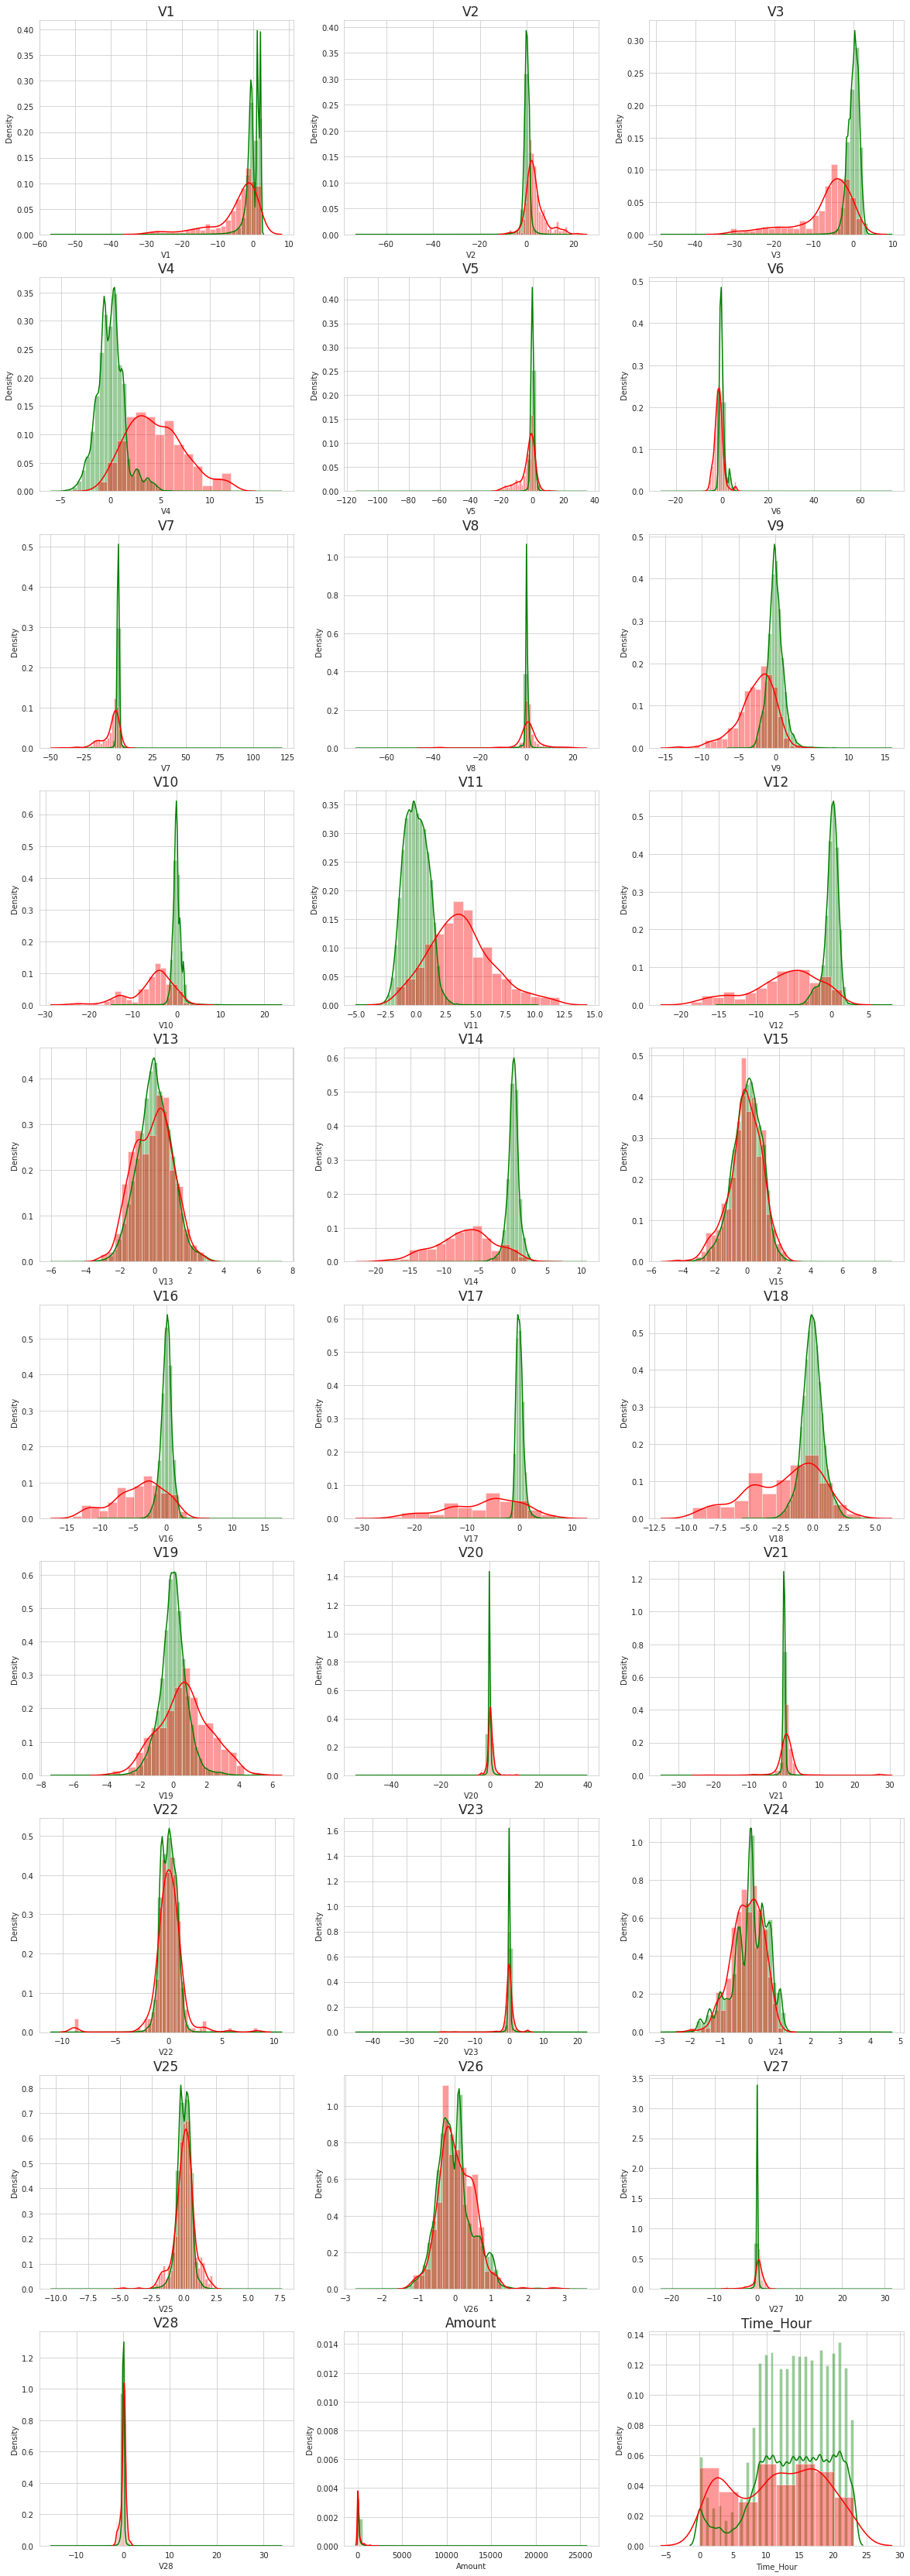

In [44]:
# plot the histogram of a variable from the dataset to see the skewness

normal_records = df.Class == 0
fraud_records = df.Class == 1

plt.figure(figsize=(20, 60))
for n, col in enumerate(cols):
  plt.subplot(10,3,n+1)
  sns.distplot(X[col][normal_records], color='green')
  sns.distplot(X[col][fraud_records], color='red')
  plt.title(col, fontsize=17)
plt.show()

### If there is skewness present in the distribution use:
- <b>Power Transformer</b> package present in the <b>preprocessing library provided by sklearn</b> to make distribution more gaussian

In [51]:
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
pt = PowerTransformer()
pt.fit(X_train)                       ## Fit the PT on training data
X_train_pt = pt.transform(X_train)    ## Then apply on all data
X_test_pt = pt.transform(X_test)

In [52]:
#Create Dataframe
X_train_pt_df = pd.DataFrame(data=X_train_pt,   columns=cols)
X_test_pt_df = pd.DataFrame(data=X_test_pt,   columns=cols)

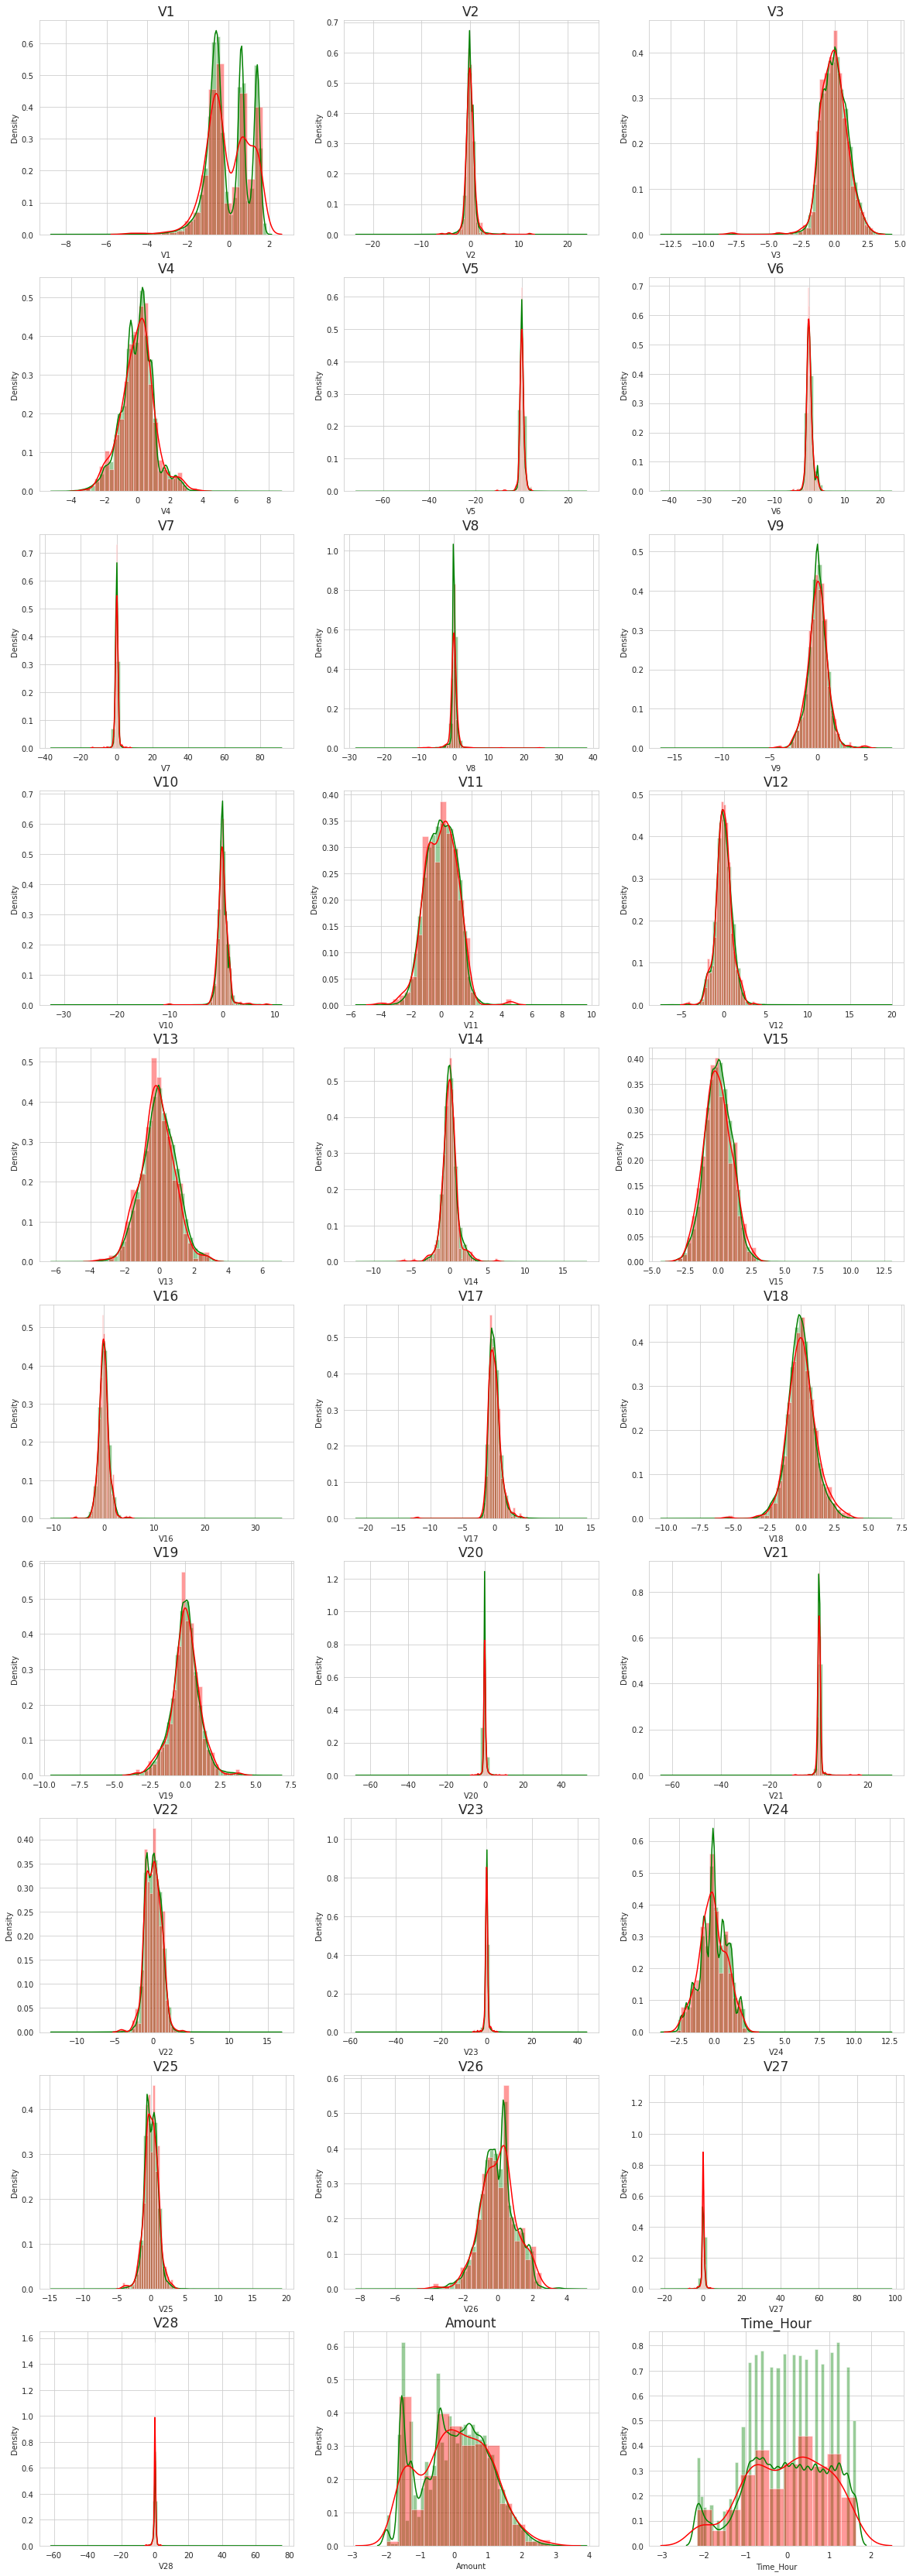

In [53]:
# plot the histogram of a variable from the train dataset again to see the result 
plt.figure(figsize=(20, 60))
for n, col in enumerate(cols):
  plt.subplot(10,3,n+1)
  sns.distplot(X_train_pt_df[col][normal_records], color='green')
  sns.distplot(X_train_pt_df[col][fraud_records], color='red')
  plt.title(col, fontsize=17)
plt.show()

## Model Building
- Build different models on the imbalanced dataset and see the result

## Common methods to be used later to analyze the resultset by different algorithm

In [55]:
#Create a dataframe to store results
df_Results = pd.DataFrame(columns=['Data_Imbalance_Handiling','Model','Accuracy','roc_value','threshold'])

In [56]:
def Plot_confusion_matrix(y_test, pred_test):
  cm = confusion_matrix(y_test, pred_test)
  plt.clf()
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Accent)
  classNames = ['Non-Fraudalent','Fraudalent']
  plt.title('Confusion Matrix - Test Data')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  tick_marks = np.arange(len(classNames))
  plt.xticks(tick_marks, classNames, rotation=45)
  plt.yticks(tick_marks, classNames)
  s = [['TN','FP'], ['FN', 'TP']]
  
  for i in range(2):
      for j in range(2):
          plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]),fontsize=12)
  plt.show()

In [57]:
def buildAndRunLogisticModels(df_Results, DataImabalance, X_train,y_train, X_test, y_test ):

  # Logistic Regression
  from sklearn import linear_model #import the package
  from sklearn.model_selection import KFold

  num_C = list(np.power(10.0, np.arange(-10, 10)))
  cv_num = KFold(n_splits=10, shuffle=True, random_state=42)

  searchCV_l2 = linear_model.LogisticRegressionCV(
          Cs= num_C
          ,penalty='l2'
          ,scoring='roc_auc'
          ,cv=cv_num
          ,random_state=42
          ,max_iter=10000
          ,fit_intercept=True
          ,solver='newton-cg'
          ,tol=10
      )

  searchCV_l1 = linear_model.LogisticRegressionCV(
          Cs=num_C
          ,penalty='l1'
          ,scoring='roc_auc'
          ,cv=cv_num
          ,random_state=42
          ,max_iter=10000
          ,fit_intercept=True
          ,solver='liblinear'
          ,tol=10
      )
  #searchCV.fit(X_train, y_train)
  searchCV_l2.fit(X_train, y_train)
  searchCV_l1.fit(X_train, y_train)
  print ('Max auc_roc for l2:', searchCV_l2.scores_[1].mean(axis=0).max())
  print ('Max auc_roc for l1:', searchCV_l1.scores_[1].mean(axis=0).max())

  print("Parameters for l2 regularisations")
  print(searchCV_l2.coef_)
  print(searchCV_l2.intercept_) 
  print(searchCV_l2.scores_) 

  print("Parameters for l1 regularisations")
  print(searchCV_l1.coef_)
  print(searchCV_l1.intercept_) 
  print(searchCV_l1.scores_) 


  #find predicted vallues
  y_pred_l2 = searchCV_l2.predict(X_test)
  y_pred_l1 = searchCV_l1.predict(X_test)
  

  #Find predicted probabilities
  y_pred_probs_l2 = searchCV_l2.predict_proba(X_test)[:,1] 
  y_pred_probs_l1 = searchCV_l1.predict_proba(X_test)[:,1] 

  # Accuaracy of L2/L1 models
  Accuracy_l2 = metrics.accuracy_score(y_pred=y_pred_l2, y_true=y_test)
  Accuracy_l1 = metrics.accuracy_score(y_pred=y_pred_l1, y_true=y_test)

  print("Accuarcy of Logistic model with l2 regularisation : {0}".format(Accuracy_l2))
  print("Confusion Matrix")
  Plot_confusion_matrix(y_test, y_pred_l2)
  print("classification Report")
  print(classification_report(y_test, y_pred_l2))
  print("Accuarcy of Logistic model with l1 regularisation : {0}".format(Accuracy_l1))
  print("Confusion Matrix")
  Plot_confusion_matrix(y_test, y_pred_l1)
  print("classification Report")
  print(classification_report(y_test, y_pred_l1))

  from sklearn.metrics import roc_auc_score
  l2_roc_value = roc_auc_score(y_test, y_pred_probs_l2)
  print("l2 roc_value: {0}" .format(l2_roc_value))
  fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs_l2)
  threshold = thresholds[np.argmax(tpr-fpr)]
  print("l2 threshold: {0}".format(threshold))

  roc_auc = metrics.auc(fpr, tpr)
  print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
  plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
  plt.legend(loc=4)
  plt.show()
  
  df_Results = df_Results.append(pd.DataFrame({'Data_Imbalance_Handiling': DataImabalance,'Model': 'Logistic Regression with L2 Regularisation','Accuracy': Accuracy_l2,'roc_value': l2_roc_value,'threshold': threshold}, index=[0]),ignore_index= True)

  l1_roc_value = roc_auc_score(y_test, y_pred_probs_l1)
  print("l1 roc_value: {0}" .format(l1_roc_value))
  fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs_l1)
  threshold = thresholds[np.argmax(tpr-fpr)]
  print("l1 threshold: {0}".format(threshold))

  roc_auc = metrics.auc(fpr, tpr)
  print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
  plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
  plt.legend(loc=4)
  plt.show()
  
  df_Results = df_Results.append(pd.DataFrame({'Data_Imbalance_Handiling': DataImabalance,'Model': 'Logistic Regression with L1 Regularisation','Accuracy': Accuracy_l1,'roc_value': l1_roc_value,'threshold': threshold}, index=[0]),ignore_index= True)
  return df_Results


In [58]:
def buildAndRunKNNModels(df_Results,DataImabalance, X_train,y_train, X_test, y_test ):
  #Evaluate KNN  model
  from sklearn.neighbors import KNeighborsClassifier
  from sklearn.metrics import roc_auc_score
  #create KNN model and fit the model with train dataset
  knn = KNeighborsClassifier(n_neighbors = 5,n_jobs=16)
  knn.fit(X_train,y_train)
  score = knn.score(X_test,y_test)
  print("model score")
  print(score)
  
  #Accuracy
  y_pred = knn.predict(X_test)
  KNN_Accuracy = metrics.accuracy_score(y_pred=y_pred, y_true=y_test)
  print("Confusion Matrix")
  Plot_confusion_matrix(y_test, y_pred)
  print("classification Report")
  print(classification_report(y_test, y_pred))


  knn_probs = knn.predict_proba(X_test)[:, 1]

  # Calculate roc auc
  knn_roc_value = roc_auc_score(y_test, knn_probs)
  print("KNN roc_value: {0}" .format(knn_roc_value))
  fpr, tpr, thresholds = metrics.roc_curve(y_test, knn_probs)
  threshold = thresholds[np.argmax(tpr-fpr)]
  print("KNN threshold: {0}".format(threshold))

  roc_auc = metrics.auc(fpr, tpr)
  print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
  plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
  plt.legend(loc=4)
  plt.show()
  
  df_Results = df_Results.append(pd.DataFrame({'Data_Imbalance_Handiling': DataImabalance,'Model': 'KNN','Accuracy': score,'roc_value': knn_roc_value,'threshold': threshold}, index=[0]),ignore_index= True)

  return df_Results

In [59]:
def buildAndRunSVMModels(df_Results, DataImabalance, X_train,y_train, X_test, y_test ):
  #Evaluate SVM model with sigmoid kernel  model
  from sklearn.svm import SVC
  from sklearn.metrics import accuracy_score
  from sklearn.metrics import roc_auc_score

  clf = SVC(kernel='sigmoid', random_state=42)
  clf.fit(X_train,y_train)
  y_pred_SVM = clf.predict(X_test)
  SVM_Score = accuracy_score(y_test,y_pred_SVM)
  print("accuracy_score : {0}".format(SVM_Score))
  print("Confusion Matrix")
  Plot_confusion_matrix(y_test, y_pred_SVM)
  print("classification Report")
  print(classification_report(y_test, y_pred_SVM))



  # Run classifier
  classifier = SVC(kernel='sigmoid' , probability=True)
  svm_probs = classifier.fit(X_train, y_train).predict_proba(X_test)[:, 1]

  # Calculate roc auc
  roc_value = roc_auc_score(y_test, svm_probs)
  
  print("SVM roc_value: {0}" .format(roc_value))
  fpr, tpr, thresholds = metrics.roc_curve(y_test, svm_probs)
  threshold = thresholds[np.argmax(tpr-fpr)]
  print("SVM threshold: {0}".format(threshold))
  roc_auc = metrics.auc(fpr, tpr)
  print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
  plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
  plt.legend(loc=4)
  plt.show()
  
  df_Results = df_Results.append(pd.DataFrame({'Data_Imbalance_Handiling': DataImabalance,'Model': 'SVM','Accuracy': SVM_Score,'roc_value': roc_value,'threshold': threshold}, index=[0]),ignore_index= True)

  return df_Results

In [60]:
def buildAndRunTreeModels(df_Results, DataImabalance, X_train,y_train, X_test, y_test ):
  #Evaluate Decision Tree model with 'gini' & 'entropy'
  from sklearn.tree import DecisionTreeClassifier
  from sklearn.metrics import roc_auc_score
  criteria = ['gini', 'entropy'] 
  scores = {} 
    
  for c in criteria: 
      dt = DecisionTreeClassifier(criterion = c, random_state=42) 
      dt.fit(X_train, y_train) 
      y_pred = dt.predict(X_test)
      test_score = dt.score(X_test, y_test) 
      tree_preds = dt.predict_proba(X_test)[:, 1]
      tree_roc_value = roc_auc_score(y_test, tree_preds)
      scores = test_score 
      print(c + " score: {0}" .format(test_score))
      print("Confusion Matrix")
      Plot_confusion_matrix(y_test, y_pred)
      print("classification Report")
      print(classification_report(y_test, y_pred))
      print(c + " tree_roc_value: {0}" .format(tree_roc_value))
      fpr, tpr, thresholds = metrics.roc_curve(y_test, tree_preds)
      threshold = thresholds[np.argmax(tpr-fpr)]
      print("Tree threshold: {0}".format(threshold))
      roc_auc = metrics.auc(fpr, tpr)
      print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
      plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
      plt.legend(loc=4)
      plt.show()
  
      df_Results = df_Results.append(pd.DataFrame({'Data_Imbalance_Handiling': DataImabalance,'Model': 'Tree Model with {0} criteria'.format(c),'Accuracy': test_score,'roc_value': tree_roc_value,'threshold': threshold}, index=[0]),ignore_index= True)

  return df_Results

In [61]:
def buildAndRunRandomForestModels(df_Results, DataImabalance, X_train,y_train, X_test, y_test ):
  #Evaluate Random Forest model

  from sklearn.ensemble import RandomForestClassifier
  from sklearn.metrics import roc_auc_score

  # Create the model with 100 trees
  RF_model = RandomForestClassifier(n_estimators=100, 
                                bootstrap = True,
                                max_features = 'sqrt', random_state=42)
  # Fit on training data
  RF_model.fit(X_train, y_train)
  RF_test_score = RF_model.score(X_test, y_test)
  RF_model.predict(X_test)

  print('Model Accuracy: {0}'.format(RF_test_score))


  # Actual class predictions
  rf_predictions = RF_model.predict(X_test)

  print("Confusion Matrix")
  Plot_confusion_matrix(y_test, rf_predictions)
  print("classification Report")
  print(classification_report(y_test, rf_predictions))

  # Probabilities for each class
  rf_probs = RF_model.predict_proba(X_test)[:, 1]

  # Calculate roc auc
  roc_value = roc_auc_score(y_test, rf_probs)

  print("Random Forest roc_value: {0}" .format(roc_value))
  fpr, tpr, thresholds = metrics.roc_curve(y_test, rf_probs)
  threshold = thresholds[np.argmax(tpr-fpr)]
  print("Random Forest threshold: {0}".format(threshold))
  roc_auc = metrics.auc(fpr, tpr)
  print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
  plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
  plt.legend(loc=4)
  plt.show()
  
  df_Results = df_Results.append(pd.DataFrame({'Data_Imbalance_Handiling': DataImabalance,'Model': 'Random Forest','Accuracy': RF_test_score,'roc_value': roc_value,'threshold': threshold}, index=[0]),ignore_index= True)

  return df_Results

In [62]:
def buildAndRunXGBoostModels(df_Results, DataImabalance,X_train,y_train, X_test, y_test ):
  #Evaluate XGboost model
  from xgboost import XGBClassifier
  from sklearn.metrics import roc_auc_score
  # fit model no training data
  XGBmodel = XGBClassifier(random_state=42)
  XGBmodel.fit(X_train, y_train)
  y_pred = XGBmodel.predict(X_test)

  XGB_test_score = XGBmodel.score(X_test, y_test)
  print('Model Accuracy: {0}'.format(XGB_test_score))

  print("Confusion Matrix")
  Plot_confusion_matrix(y_test, y_pred)
  print("classification Report")
  print(classification_report(y_test, y_pred))
  # Probabilities for each class
  XGB_probs = XGBmodel.predict_proba(X_test)[:, 1]

  # Calculate roc auc
  XGB_roc_value = roc_auc_score(y_test, XGB_probs)

  print("XGboost roc_value: {0}" .format(XGB_roc_value))
  fpr, tpr, thresholds = metrics.roc_curve(y_test, XGB_probs)
  threshold = thresholds[np.argmax(tpr-fpr)]
  print("XGBoost threshold: {0}".format(threshold))
  roc_auc = metrics.auc(fpr, tpr)
  print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
  plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
  plt.legend(loc=4)
  plt.show()
  
  df_Results = df_Results.append(pd.DataFrame({'Data_Imbalance_Handiling': DataImabalance,'Model': 'XGBoost','Accuracy': XGB_test_score,'roc_value': XGB_roc_value,'threshold': threshold}, index=[0]),ignore_index= True)

  return df_Results

Logistic Regression with L1 And L2 Regularisation
Max auc_roc for l2: 0.9793243350932137
Max auc_roc for l1: 0.9813863284665615
Parameters for l2 regularisations
[[-0.12057354 -0.05667162 -0.24676384  0.56302425  0.04177003  0.02865183
  -0.1199155  -0.21207851 -0.14650231 -0.19007501  0.16554597 -0.48143726
  -0.08213217 -0.65498127 -0.07135179 -0.20376407 -0.03238876  0.03912358
  -0.0644163  -0.03658189  0.11584267  0.1420345  -0.08100022 -0.0095216
  -0.00814926  0.00400496 -0.07906575 -0.049874    0.01858732  0.04176736]]
[-8.03924925]
{1: array([[0.92903108, 0.92885651, 0.92885651, 0.92885651, 0.92885651,
        0.9294719 , 0.97835981, 0.99395793, 0.99645212, 0.99665934,
        0.99665934, 0.99634411, 0.99634411, 0.99634411, 0.99634411,
        0.99634411, 0.99634411, 0.99634411, 0.99634411, 0.99634411],
       [0.84056194, 0.84069529, 0.84069529, 0.84069529, 0.84069529,
        0.84103321, 0.90904256, 0.95494784, 0.95968627, 0.9610637 ,
        0.9610637 , 0.9610637 , 0.961063

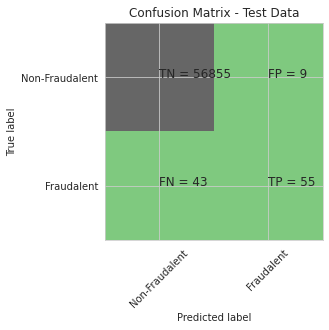

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.86      0.56      0.68        98

    accuracy                           1.00     56962
   macro avg       0.93      0.78      0.84     56962
weighted avg       1.00      1.00      1.00     56962

Accuarcy of Logistic model with l1 regularisation : 0.9991397773954567
Confusion Matrix


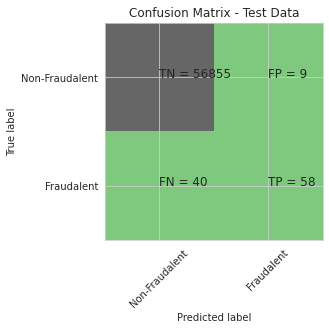

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.87      0.59      0.70        98

    accuracy                           1.00     56962
   macro avg       0.93      0.80      0.85     56962
weighted avg       1.00      1.00      1.00     56962

l2 roc_value: 0.9811167784502658
l2 threshold: 0.003049146260330956
ROC for the test dataset 98.1%


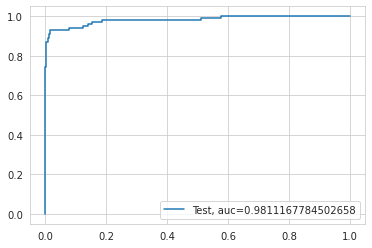

l1 roc_value: 0.9829810546897431
l1 threshold: 0.006689242751335789
ROC for the test dataset 98.3%


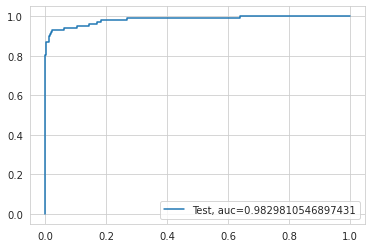

Time Taken by Model: --- 131.9117579460144 seconds ---
--------------------------------------------------------------------------------


In [ ]:
# Logistic Regression
import time

#Run Logistic Regression with L1 And L2 Regularisation
print("Logistic Regression with L1 And L2 Regularisation")
start_time = time.time()
df_Results = buildAndRunLogisticModels(df_Results,"Power Transformer",X_train_pt_df,y_train, X_test_pt_df, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )

### Similarly explore other algorithms by building models like:
- KNN
- SVM
- Decision Tree
- Random Forest
- XGBoost

KNN Model
model score
0.9995259997893332
Confusion Matrix


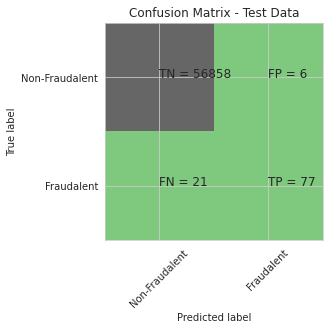

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.93      0.79      0.85        98

    accuracy                           1.00     56962
   macro avg       0.96      0.89      0.93     56962
weighted avg       1.00      1.00      1.00     56962

KNN roc_value: 0.9284628630574345
KNN threshold: 0.2
ROC for the test dataset 92.8%


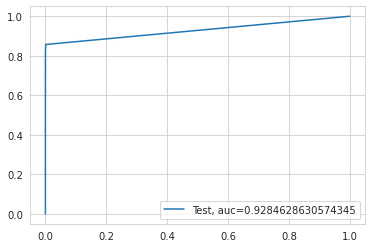

Time Taken by Model: --- 936.909704208374 seconds ---
--------------------------------------------------------------------------------


In [65]:
#Run KNN Model
print("KNN Model")
start_time = time.time()
df_Results = buildAndRunKNNModels(df_Results,"Power Transformer",X_train_pt_df,y_train, X_test_pt_df, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )

Decision Tree Models with  'gini' & 'entropy' criteria
gini score: 0.9990695551420246
Confusion Matrix


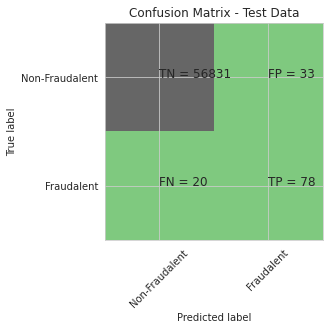

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.70      0.80      0.75        98

    accuracy                           1.00     56962
   macro avg       0.85      0.90      0.87     56962
weighted avg       1.00      1.00      1.00     56962

gini tree_roc_value: 0.89766901766334
Tree threshold: 1.0
ROC for the test dataset 89.8%


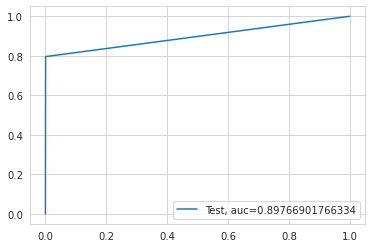

entropy score: 0.9991573329588147
Confusion Matrix


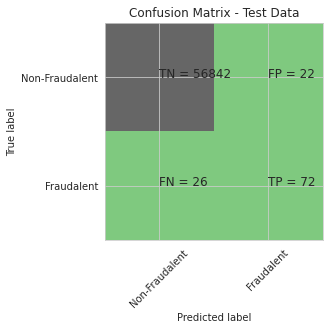

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.77      0.73      0.75        98

    accuracy                           1.00     56962
   macro avg       0.88      0.87      0.87     56962
weighted avg       1.00      1.00      1.00     56962

entropy tree_roc_value: 0.8671534947687572
Tree threshold: 1.0
ROC for the test dataset 86.7%


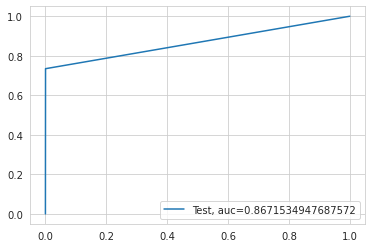

Time Taken by Model: --- 27.70287013053894 seconds ---
--------------------------------------------------------------------------------


In [66]:
#Run Decision Tree Models with  'gini' & 'entropy' criteria
print("Decision Tree Models with  'gini' & 'entropy' criteria")
start_time = time.time()
df_Results = buildAndRunTreeModels(df_Results,"Power Transformer",X_train_pt_df,y_train, X_test_pt_df, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )

Random Forest Model
Model Accuracy: 0.9995611109160493
Confusion Matrix


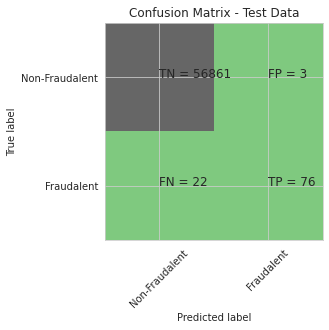

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.78      0.86        98

    accuracy                           1.00     56962
   macro avg       0.98      0.89      0.93     56962
weighted avg       1.00      1.00      1.00     56962

Random Forest roc_value: 0.962755658326921
Random Forest threshold: 0.01
ROC for the test dataset 96.3%


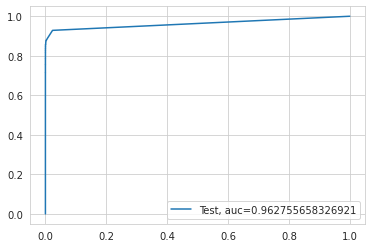

Time Taken by Model: --- 178.5157277584076 seconds ---
--------------------------------------------------------------------------------


In [67]:
#Run Random Forest Model
print("Random Forest Model")
start_time = time.time()
df_Results = buildAndRunRandomForestModels(df_Results,"Power Transformer",X_train_pt_df,y_train, X_test_pt_df, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )

XGBoost Model
[12:25:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model Accuracy: 0.9996137776061234
Confusion Matrix


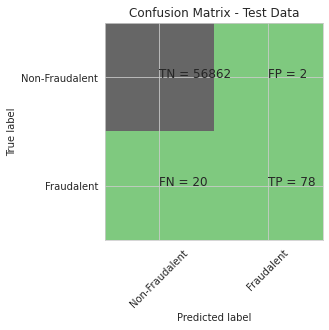

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.97      0.80      0.88        98

    accuracy                           1.00     56962
   macro avg       0.99      0.90      0.94     56962
weighted avg       1.00      1.00      1.00     56962

XGboost roc_value: 0.9823083073972414
XGBoost threshold: 7.13571353117004e-05
ROC for the test dataset 98.2%


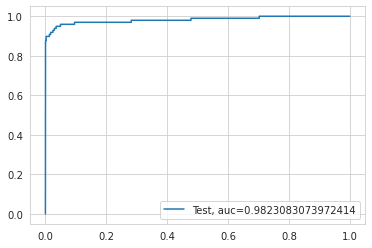

Time Taken by Model: --- 32.88163638114929 seconds ---
--------------------------------------------------------------------------------


In [68]:
#Run XGBoost Modela
print("XGBoost Model")
start_time = time.time()
df_Results = buildAndRunXGBoostModels(df_Results,"Power Transformer",X_train_pt_df,y_train, X_test_pt_df, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )

SVM Model with Sigmoid Kernel
accuracy_score : 0.99875355500158
Confusion Matrix


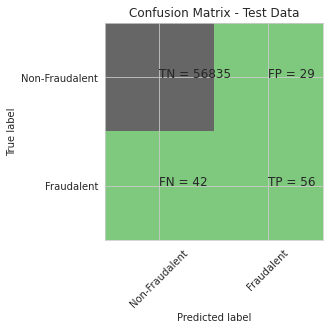

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.66      0.57      0.61        98

    accuracy                           1.00     56962
   macro avg       0.83      0.79      0.81     56962
weighted avg       1.00      1.00      1.00     56962

SVM roc_value: 0.8564143017927486
SVM threshold: 0.00021164818837383722
ROC for the test dataset 85.6%


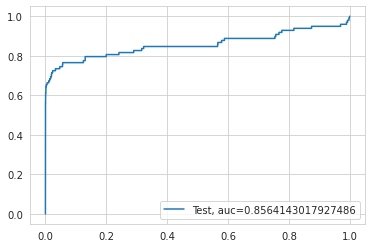

Time Taken by Model: --- 83.44696307182312 seconds ---


In [69]:
#Run SVM Model with Sigmoid Kernel
print("SVM Model with Sigmoid Kernel")
start_time = time.time()
df_Results = buildAndRunSVMModels(df_Results,"Power Transformer",X_train_pt_df,y_train, X_test_pt_df, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))

In [70]:
df_Results.head()

,Data_Imbalance_Handiling,Model,Accuracy,roc_value,threshold
0,Power Transformer,Logistic Regression with L2 Regularisation,0.999087,0.981117,0.003049
1,Power Transformer,Logistic Regression with L1 Regularisation,0.999140,0.982981,0.006689
2,Power Transformer,KNN,0.999526,0.928463,0.200000
3,Power Transformer,Tree Model with gini criteria,0.999070,0.897669,1.000000
4,Power Transformer,Tree Model with entropy criteria,0.999157,0.867153,1.000000


## Perform cross validation with Repeated KFold

In [73]:
from sklearn.model_selection import RepeatedKFold
rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=None)
# X is the feature set and y is the target
for train_index, test_index in rkf.split(X,y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

TRAIN: [     1      2      3 ... 284804 284805 284806] TEST: [     0      5     17 ... 284792 284795 284798]
TRAIN: [     0      1      2 ... 284803 284804 284806] TEST: [     3     19     25 ... 284797 284799 284805]
TRAIN: [     0      2      3 ... 284804 284805 284806] TEST: [     1      4      9 ... 284774 284787 284803]
TRAIN: [     0      1      3 ... 284803 284805 284806] TEST: [     2      7     11 ... 284794 284801 284804]
TRAIN: [     0      1      2 ... 284803 284804 284805] TEST: [     6      8     10 ... 284800 284802 284806]
TRAIN: [     0      1      2 ... 284803 284804 284806] TEST: [     4      5      7 ... 284795 284800 284805]
TRAIN: [     0      1      4 ... 284804 284805 284806] TEST: [     2      3      6 ... 284788 284799 284801]
TRAIN: [     0      1      2 ... 284804 284805 284806] TEST: [     9     22     24 ... 284765 284782 284797]
TRAIN: [     1      2      3 ... 284804 284805 284806] TEST: [     0     10     29 ... 284789 284792 284796]
TRAIN: [     0     

Logistic Regression with L1 And L2 Regularisation
Max auc_roc for l2: 0.9829014939627785
Max auc_roc for l1: 0.9697220076936265
Parameters for l2 regularisations
[[ 1.25822410e-02  4.02892306e-02 -8.53064565e-02  2.22985109e-01
   8.52847260e-02 -4.77204058e-02 -2.64281938e-02 -1.13842347e-01
  -7.98604863e-02 -1.76551646e-01  1.37154360e-01 -1.95098747e-01
  -3.92771951e-02 -3.75982942e-01 -5.33019133e-03 -1.07296227e-01
  -9.49007032e-02 -1.15464589e-02  3.44575344e-03 -2.36691622e-02
   4.17205654e-02  2.65469385e-02 -1.17074586e-02 -1.17948973e-02
  -9.57047041e-03  1.38825988e-03 -6.47318944e-03 -1.97630220e-03
   3.56937619e-04  1.75414551e-03]]
[-7.43833575]
{1: array([[0.68512822, 0.68667336, 0.70335595, 0.81488303, 0.95397513,
        0.99010028, 0.99441051, 0.99118013, 0.9881778 , 0.98176307,
        0.98176307, 0.98176307, 0.98176307, 0.98176307, 0.98176307,
        0.98176307, 0.98176307, 0.98176307, 0.98176307, 0.98176307],
       [0.49410127, 0.49562488, 0.52037797, 0.700

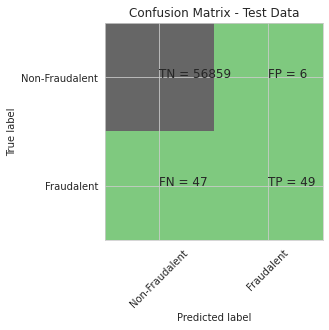

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56865
           1       0.89      0.51      0.65        96

    accuracy                           1.00     56961
   macro avg       0.95      0.76      0.82     56961
weighted avg       1.00      1.00      1.00     56961

Accuarcy of Logistic model with l1 regularisation : 0.9990870946788153
Confusion Matrix


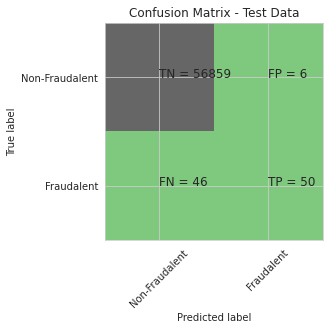

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56865
           1       0.89      0.52      0.66        96

    accuracy                           1.00     56961
   macro avg       0.95      0.76      0.83     56961
weighted avg       1.00      1.00      1.00     56961

l2 roc_value: 0.984916945103901
l2 threshold: 0.0013332335518140327
ROC for the test dataset 98.5%


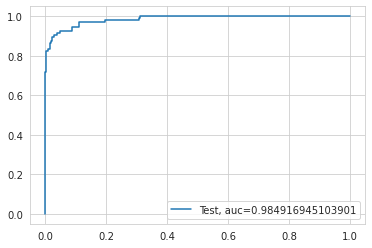

l1 roc_value: 0.8463770186699493
l1 threshold: 0.06245950989221094
ROC for the test dataset 84.6%


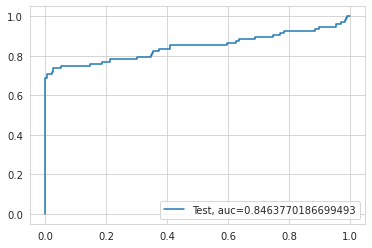

Time Taken by Model: --- 248.74829268455505 seconds ---
--------------------------------------------------------------------------------


In [74]:
#Run Logistic Regression with L1 And L2 Regularisation
print("Logistic Regression with L1 And L2 Regularisation")
start_time = time.time()
df_Results = buildAndRunLogisticModels(df_Results,"RepeatedKFold Cross Validation", X_train_cv,y_train_cv, X_test_cv, y_test_cv)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )

### Similarly explore other algorithms by building models like:
- KNN
- SVM
- Decision Tree
- Random Forest
- XGBoost

KNN Model
model score
0.9992099857797441
Confusion Matrix


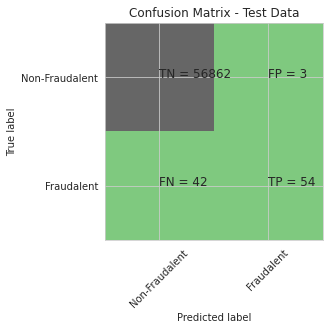

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56865
           1       0.95      0.56      0.71        96

    accuracy                           1.00     56961
   macro avg       0.97      0.78      0.85     56961
weighted avg       1.00      1.00      1.00     56961

KNN roc_value: 0.8695996915208536
KNN threshold: 0.2
ROC for the test dataset 87.0%


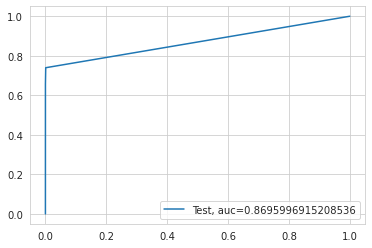

Time Taken by Model: --- 164.40276622772217 seconds ---
--------------------------------------------------------------------------------


In [75]:
#Run KNN Model
print("KNN Model")
start_time = time.time()
df_Results = buildAndRunKNNModels(df_Results,"RepeatedKFold Cross Validation",X_train_cv,y_train_cv, X_test_cv, y_test_cv)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )

Decision Tree Models with  'gini' & 'entropy' criteria
gini score: 0.9991748740366215
Confusion Matrix


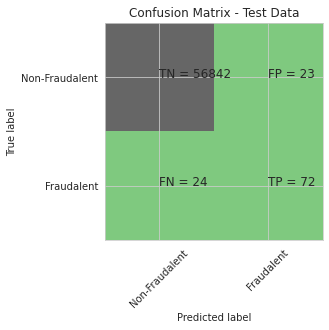

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56865
           1       0.76      0.75      0.75        96

    accuracy                           1.00     56961
   macro avg       0.88      0.87      0.88     56961
weighted avg       1.00      1.00      1.00     56961

gini tree_roc_value: 0.8747977666402885
Tree threshold: 1.0
ROC for the test dataset 87.5%


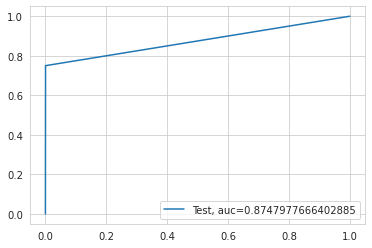

entropy score: 0.9991748740366215
Confusion Matrix


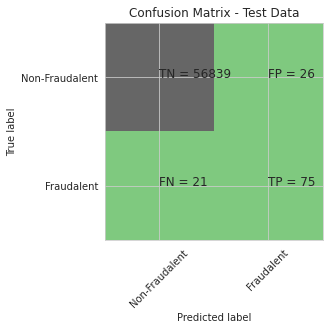

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56865
           1       0.74      0.78      0.76        96

    accuracy                           1.00     56961
   macro avg       0.87      0.89      0.88     56961
weighted avg       1.00      1.00      1.00     56961

entropy tree_roc_value: 0.8903963883759781
Tree threshold: 1.0
ROC for the test dataset 89.0%


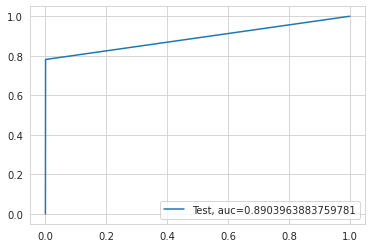

Time Taken by Model: --- 26.903383255004883 seconds ---
--------------------------------------------------------------------------------


In [76]:
#Run Decision Tree Models with  'gini' & 'entropy' criteria
print("Decision Tree Models with  'gini' & 'entropy' criteria")
start_time = time.time()
df_Results = buildAndRunTreeModels(df_Results,"RepeatedKFold Cross Validation",X_train_cv,y_train_cv, X_test_cv, y_test_cv)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )

Random Forest Model
Model Accuracy: 0.9995259914678464
Confusion Matrix


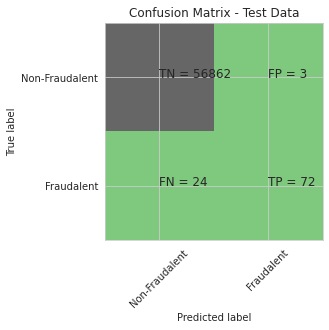

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56865
           1       0.96      0.75      0.84        96

    accuracy                           1.00     56961
   macro avg       0.98      0.87      0.92     56961
weighted avg       1.00      1.00      1.00     56961

Random Forest roc_value: 0.9354995566986136
Random Forest threshold: 0.01
ROC for the test dataset 93.5%


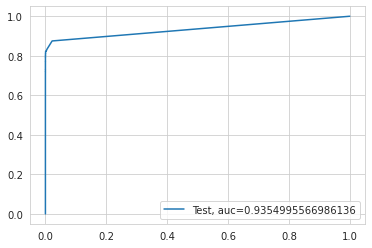

Time Taken by Model: --- 174.37110137939453 seconds ---
--------------------------------------------------------------------------------


In [77]:
#Run Random Forest Model
print("Random Forest Model")
start_time = time.time()
df_Results = buildAndRunRandomForestModels(df_Results,"RepeatedKFold Cross Validation",X_train_cv,y_train_cv, X_test_cv, y_test_cv)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )

XGBoost Model
[12:41:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model Accuracy: 0.9995435473394076
Confusion Matrix


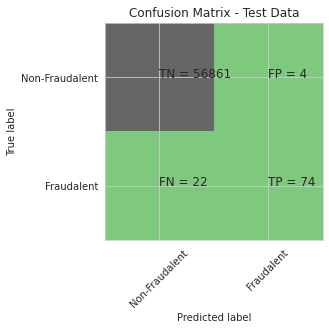

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56865
           1       0.95      0.77      0.85        96

    accuracy                           1.00     56961
   macro avg       0.97      0.89      0.93     56961
weighted avg       1.00      1.00      1.00     56961

XGboost roc_value: 0.9720089063278526
XGBoost threshold: 0.00011747129610739648
ROC for the test dataset 97.2%


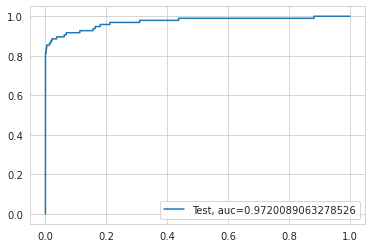

Time Taken by Model: --- 20.096410989761353 seconds ---
--------------------------------------------------------------------------------


In [78]:
#Run XGBoost Modela
print("XGBoost Model")
start_time = time.time()
df_Results = buildAndRunXGBoostModels(df_Results,"RepeatedKFold Cross Validation",X_train_cv,y_train_cv, X_test_cv, y_test_cv)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )

SVM Model with Sigmoid Kernel
accuracy_score : 0.9983673039448043
Confusion Matrix


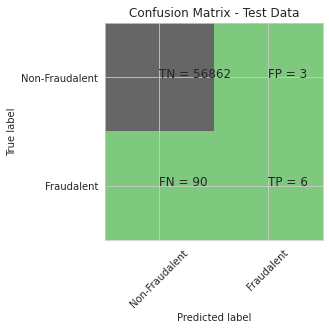

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56865
           1       0.67      0.06      0.11        96

    accuracy                           1.00     56961
   macro avg       0.83      0.53      0.56     56961
weighted avg       1.00      1.00      1.00     56961

SVM roc_value: 0.47174741346463844
SVM threshold: 0.0028507342493942767
ROC for the test dataset 47.2%


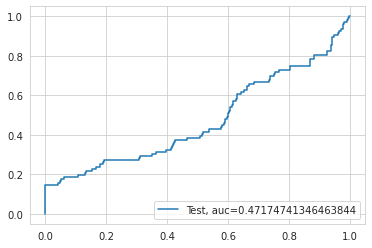

Time Taken by Model: --- 221.25783252716064 seconds ---


In [79]:
#Run SVM Model with Sigmoid Kernel
print("SVM Model with Sigmoid Kernel")
start_time = time.time()
df_Results = buildAndRunSVMModels(df_Results,"RepeatedKFold Cross Validation",X_train_cv,y_train_cv, X_test_cv, y_test_cv)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))

In [80]:
#print the matrix with models and result
df_Results

,Data_Imbalance_Handiling,Model,Accuracy,roc_value,threshold
0,Power Transformer,Logistic Regression with L2 Regularisation,0.999087,0.981117,0.003049
1,Power Transformer,Logistic Regression with L1 Regularisation,0.999140,0.982981,0.006689
2,Power Transformer,KNN,0.999526,0.928463,0.200000
3,Power Transformer,Tree Model with gini criteria,0.999070,0.897669,1.000000
4,Power Transformer,Tree Model with entropy criteria,0.999157,0.867153,1.000000
5,Power Transformer,Random Forest,0.999561,0.962756,0.010000
6,Power Transformer,XGBoost,0.999614,0.982308,0.000071
7,Power Transformer,SVM,0.998754,0.856414,0.000212
8,RepeatedKFold Cross Validation,Logistic Regression with L2 Regularisation,0.999070,0.984917,0.001333
9,RepeatedKFold Cross Validation,Logistic Regression with L1 Regularisation,0.999087,0.846377,0.062460


### Observation
- XGBoost with Repeated KFold cross validation has provided the best results

## Perform cross validation with StratifiedKFold

In [81]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=None)
# X is the feature set and y is the target
for train_index, test_index in skf.split(X,y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train_SKF_cv, X_test_SKF_cv = X.iloc[train_index], X.iloc[test_index]
    y_train_SKF_cv, y_test_SKF_cv = y.iloc[train_index], y.iloc[test_index]

TRAIN: [ 30473  30496  31002 ... 284804 284805 284806] TEST: [    0     1     2 ... 57017 57018 57019]
TRAIN: [     0      1      2 ... 284804 284805 284806] TEST: [ 30473  30496  31002 ... 113964 113965 113966]
TRAIN: [     0      1      2 ... 284804 284805 284806] TEST: [ 81609  82400  83053 ... 170946 170947 170948]
TRAIN: [     0      1      2 ... 284804 284805 284806] TEST: [150654 150660 150661 ... 227866 227867 227868]
TRAIN: [     0      1      2 ... 227866 227867 227868] TEST: [212516 212644 213092 ... 284804 284805 284806]


Logistic Regression with L1 And L2 Regularisation
Max auc_roc for l2: 0.9823272838105981
Max auc_roc for l1: 0.9652106893977332
Parameters for l2 regularisations
[[ 0.0067011   0.06155515 -0.06691804  0.21866087  0.05391895 -0.03194959
  -0.02279303 -0.11489881 -0.06974409 -0.16366401  0.12778289 -0.19153114
  -0.03723969 -0.36079446  0.00363826 -0.08790817 -0.07278798 -0.00075505
   0.0039105  -0.02809271  0.03808873  0.02336725 -0.01164201 -0.00998327
  -0.0065266   0.00630087 -0.01008763 -0.00168392  0.00039854 -0.00048121]]
[-7.4147796]
{1: array([[0.69243733, 0.69420039, 0.71446882, 0.83768575, 0.95579612,
        0.97136042, 0.98915673, 0.99473675, 0.99128052, 0.99117906,
        0.99117906, 0.99117906, 0.99117906, 0.99117906, 0.99117906,
        0.99117906, 0.99117906, 0.99117906, 0.99117906, 0.99117906],
       [0.60693506, 0.60857913, 0.62907346, 0.76877212, 0.90897794,
        0.94878664, 0.96037845, 0.98185154, 0.98547094, 0.9832776 ,
        0.97954872, 0.97954872, 0.979548

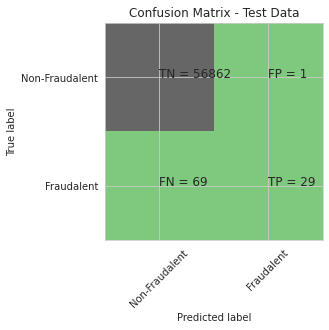

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.97      0.30      0.45        98

    accuracy                           1.00     56961
   macro avg       0.98      0.65      0.73     56961
weighted avg       1.00      1.00      1.00     56961

Accuarcy of Logistic model with l1 regularisation : 0.9987535331191517
Confusion Matrix


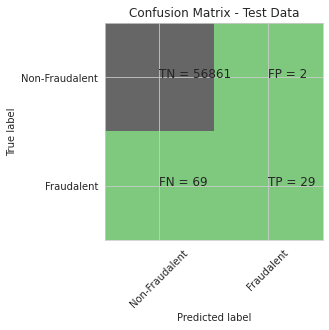

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.94      0.30      0.45        98

    accuracy                           1.00     56961
   macro avg       0.97      0.65      0.72     56961
weighted avg       1.00      1.00      1.00     56961

l2 roc_value: 0.9833681885606185
l2 threshold: 0.0015583263550410964
ROC for the test dataset 98.3%


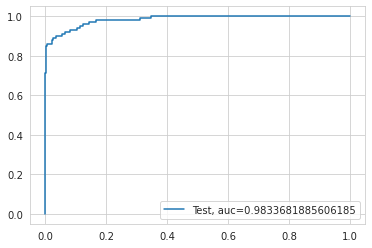

l1 roc_value: 0.8890758561483437
l1 threshold: 0.021087492766199863
ROC for the test dataset 88.9%


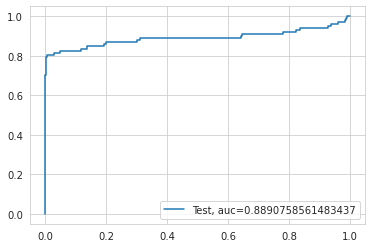

Time Taken by Model: --- 226.18986344337463 seconds ---
--------------------------------------------------------------------------------


In [82]:
#Run Logistic Regression with L1 And L2 Regularisation
print("Logistic Regression with L1 And L2 Regularisation")
start_time = time.time()
df_Results = buildAndRunLogisticModels(df_Results,"StratifiedKFold Cross Validation", X_train_SKF_cv,y_train_SKF_cv, X_test_SKF_cv, y_test_SKF_cv)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )

### Similarly explore other algorithms by building models like:
- KNN
- SVM
- Decision Tree
- Random Forest
- XGBoost

KNN Model
model score
0.9991924299081828
Confusion Matrix


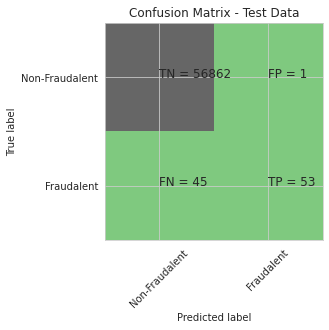

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.98      0.54      0.70        98

    accuracy                           1.00     56961
   macro avg       0.99      0.77      0.85     56961
weighted avg       1.00      1.00      1.00     56961

KNN roc_value: 0.8057457828285457
KNN threshold: 0.2
ROC for the test dataset 80.6%


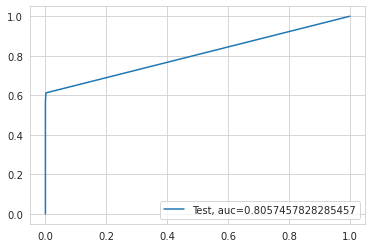

Time Taken by Model: --- 161.4589262008667 seconds ---
--------------------------------------------------------------------------------


In [84]:
#Run KNN Model
print("KNN Model")
start_time = time.time()
df_Results = buildAndRunKNNModels(df_Results,"StratifiedKFold Cross Validation",X_train_SKF_cv,y_train_SKF_cv, X_test_SKF_cv, y_test_SKF_cv)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )

Decision Tree Models with  'gini' & 'entropy' criteria
gini score: 0.998841312476958
Confusion Matrix


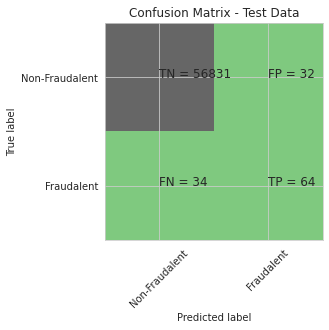

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.67      0.65      0.66        98

    accuracy                           1.00     56961
   macro avg       0.83      0.83      0.83     56961
weighted avg       1.00      1.00      1.00     56961

gini tree_roc_value: 0.8262492341959029
Tree threshold: 1.0
ROC for the test dataset 82.6%


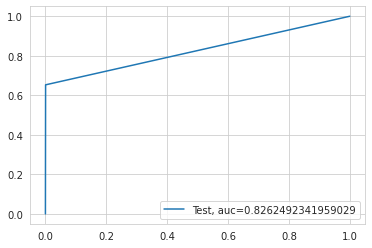

entropy score: 0.9990168711925703
Confusion Matrix


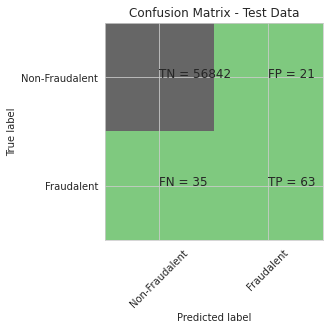

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.75      0.64      0.69        98

    accuracy                           1.00     56961
   macro avg       0.87      0.82      0.85     56961
weighted avg       1.00      1.00      1.00     56961

entropy tree_roc_value: 0.8212439170839185
Tree threshold: 1.0
ROC for the test dataset 82.1%


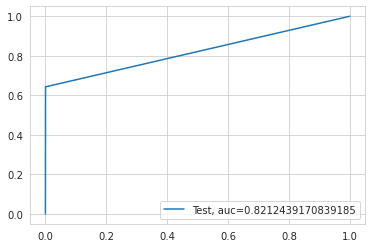

Time Taken by Model: --- 25.64387273788452 seconds ---
--------------------------------------------------------------------------------


In [85]:
#Run Decision Tree Models with  'gini' & 'entropy' criteria
print("Decision Tree Models with  'gini' & 'entropy' criteria")
start_time = time.time()
df_Results = buildAndRunTreeModels(df_Results,"StratifiedKFold Cross Validation",X_train_SKF_cv,y_train_SKF_cv, X_test_SKF_cv, y_test_SKF_cv)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )

Random Forest Model
Model Accuracy: 0.9994382121100402
Confusion Matrix


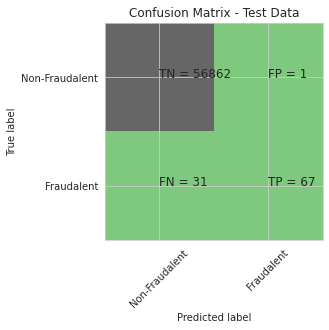

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.99      0.68      0.81        98

    accuracy                           1.00     56961
   macro avg       0.99      0.84      0.90     56961
weighted avg       1.00      1.00      1.00     56961

Random Forest roc_value: 0.9464721329855826
Random Forest threshold: 0.01
ROC for the test dataset 94.6%


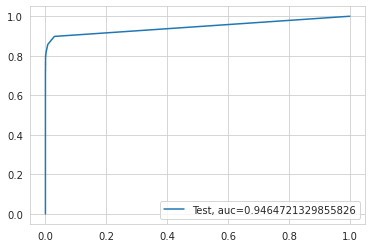

Time Taken by Model: --- 167.36018085479736 seconds ---
--------------------------------------------------------------------------------


In [86]:
#Run Random Forest Model
print("Random Forest Model")
start_time = time.time()
df_Results = buildAndRunRandomForestModels(df_Results,"StratifiedKFold Cross Validation",X_train_SKF_cv,y_train_SKF_cv, X_test_SKF_cv, y_test_SKF_cv)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )

XGBoost Model
[12:57:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model Accuracy: 0.9994382121100402
Confusion Matrix


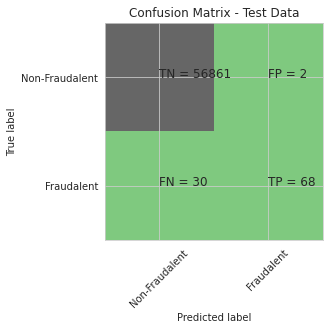

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.97      0.69      0.81        98

    accuracy                           1.00     56961
   macro avg       0.99      0.85      0.90     56961
weighted avg       1.00      1.00      1.00     56961

XGboost roc_value: 0.9728122049164354
XGBoost threshold: 0.00010038168693426996
ROC for the test dataset 97.3%


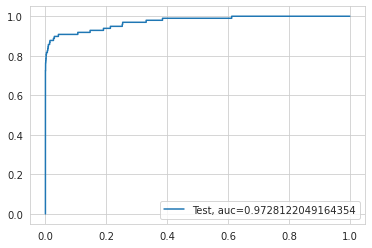

Time Taken by Model: --- 20.082781553268433 seconds ---
--------------------------------------------------------------------------------


In [87]:
#Run XGBoost Modela
print("XGBoost Model")
start_time = time.time()
df_Results = buildAndRunXGBoostModels(df_Results,"StratifiedKFold Cross Validation",X_train_SKF_cv,y_train_SKF_cv, X_test_SKF_cv, y_test_SKF_cv)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )

SVM Model with Sigmoid Kernel
accuracy_score : 0.9982795245869981
Confusion Matrix


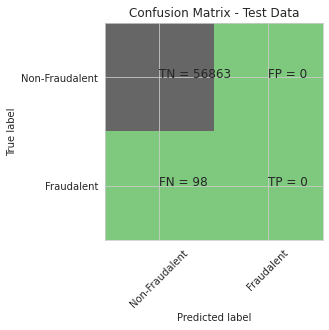

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56961
   macro avg       0.50      0.50      0.50     56961
weighted avg       1.00      1.00      1.00     56961

SVM roc_value: 0.40177034885494567
SVM threshold: 0.004312414927247947
ROC for the test dataset 40.2%


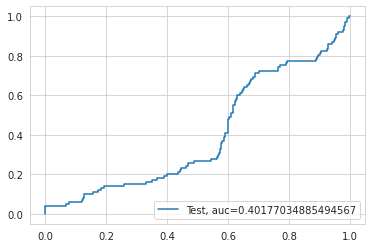

Time Taken by Model: --- 149.3405590057373 seconds ---


In [88]:
#Run SVM Model with Sigmoid Kernel
print("SVM Model with Sigmoid Kernel")
start_time = time.time()
df_Results = buildAndRunSVMModels(df_Results,"StratifiedKFold Cross Validation",X_train_SKF_cv,y_train_SKF_cv, X_test_SKF_cv, y_test_SKF_cv)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))

In [89]:
df_Results

,Data_Imbalance_Handiling,Model,Accuracy,roc_value,threshold
0,Power Transformer,Logistic Regression with L2 Regularisation,0.999087,0.981117,0.003049
1,Power Transformer,Logistic Regression with L1 Regularisation,0.999140,0.982981,0.006689
2,Power Transformer,KNN,0.999526,0.928463,0.200000
3,Power Transformer,Tree Model with gini criteria,0.999070,0.897669,1.000000
4,Power Transformer,Tree Model with entropy criteria,0.999157,0.867153,1.000000
5,Power Transformer,Random Forest,0.999561,0.962756,0.010000
6,Power Transformer,XGBoost,0.999614,0.982308,0.000071
7,Power Transformer,SVM,0.998754,0.856414,0.000212
8,RepeatedKFold Cross Validation,Logistic Regression with L2 Regularisation,0.999070,0.984917,0.001333
9,RepeatedKFold Cross Validation,Logistic Regression with L1 Regularisation,0.999087,0.846377,0.062460


## Observations
- From the result its evident that Logistic Regression with L2 Regularisation for StratifiedKFold cross validation has provided best result

#### Proceed with the model which shows the best result 
- Apply the best hyperparameter on the model
- Predict on the test dataset

In [91]:
# Logistic Regression
from sklearn import linear_model #import the package
from sklearn.model_selection import KFold

num_C = list(np.power(10.0, np.arange(-10, 10)))
cv_num = KFold(n_splits=10, shuffle=True, random_state=42)

clf = linear_model.LogisticRegressionCV(
          Cs= num_C
          ,penalty='l2'
          ,scoring='roc_auc'
          ,cv=cv_num
          ,random_state=42
          ,max_iter=10000
          ,fit_intercept=True
          ,solver='newton-cg'
          ,tol=10
      )

clf.fit(X_train, y_train)
print ('Max auc_roc for l2:', clf.scores_[1].mean(axis=0).max())

print("Parameters for l2 regularisations")
print(clf.coef_)
print(clf.intercept_) 
print(clf.scores_) 

#find predicted vallues
y_pred_l2 = clf.predict(X_test)

#Find predicted probabilities
y_pred_probs_l2 = clf.predict_proba(X_test)[:,1] 

# Accuaracy of L2/L1 models
Accuracy_l2 = metrics.accuracy_score(y_pred=y_pred_l2, y_true=y_test)
print("Accuarcy of Logistic model with l2 regularisation : {0}".format(Accuracy_l2))

Max auc_roc for l2: 0.9810901841794308
Parameters for l2 regularisations
[[ 1.07185747e-02  4.08551497e-02 -8.39251368e-02  2.40931325e-01
   9.00736259e-02 -4.44308231e-02 -3.84455180e-02 -1.20448671e-01
  -8.14792708e-02 -1.67170375e-01  1.31960547e-01 -2.01836025e-01
  -3.62146147e-02 -3.80405232e-01 -7.54741914e-03 -1.00168465e-01
  -8.35996499e-02 -4.63571865e-03  7.77792117e-03 -1.69490183e-02
   4.19676290e-02  3.03264032e-02 -1.63140461e-02 -1.26408356e-02
  -1.47517777e-02  5.99753507e-03 -1.08176800e-02 -3.40022549e-03
   3.19031568e-04 -6.21432811e-04]]
[-7.44248374]
{1: array([[0.59153155, 0.5943887 , 0.62021224, 0.79121256, 0.97101413,
        0.98719749, 0.98795604, 0.99070895, 0.99092873, 0.9888427 ,
        0.9888427 , 0.9888427 , 0.9888427 , 0.9888427 , 0.9888427 ,
        0.9888427 , 0.9888427 , 0.9888427 , 0.9888427 , 0.9888427 ],
       [0.65688019, 0.65859402, 0.67241531, 0.7969054 , 0.93418636,
        0.93929756, 0.95824065, 0.95914984, 0.95566762, 0.94099321,
  

In [92]:
from sklearn.metrics import roc_auc_score
l2_roc_value = roc_auc_score(y_test, y_pred_probs_l2)
print("l2 roc_value: {0}" .format(l2_roc_value))
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs_l2)
threshold = thresholds[np.argmax(tpr-fpr)]
print("l2 threshold: {0}".format(threshold))

l2 roc_value: 0.9848250534034659
l2 threshold: 0.0017044998455443073


### Print the important features of the best model to understand the dataset
- This will not give much explanation on the already transformed dataset
- But it will help us in understanding if the dataset is not PCA transformed

In [95]:
coefficients = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(clf.coef_))], axis = 1)
coefficients.columns = ['Feature','Importance Coefficient']
coefficients

,Feature,Importance Coefficient
0,V1,0.010719
1,V2,0.040855
2,V3,-0.083925
3,V4,0.240931
4,V5,0.090074
5,V6,-0.044431
6,V7,-0.038446
7,V8,-0.120449
8,V9,-0.081479
9,V10,-0.167170


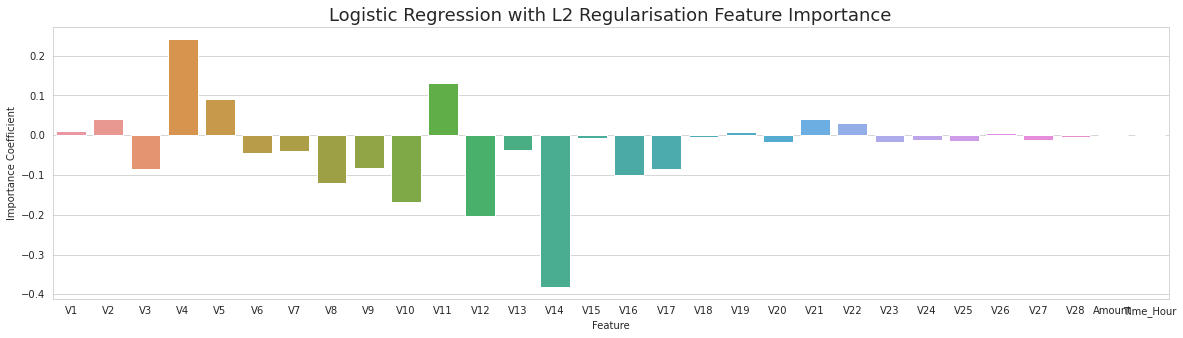

In [96]:
plt.figure(figsize=(20,5))
sns.barplot(x='Feature', y='Importance Coefficient', data=coefficients)
plt.title("Logistic Regression with L2 Regularisation Feature Importance", fontsize=18)
plt.show()

## Observations:
- V4, V11, V5 has (+)ve importance
- V10, V12, V14 has (-)ve importance

## Model building with balancing Classes

##### Perform class balancing with :
- Random Oversampling
- SMOTE
- ADASYN

## Model Building
- Build different models on the balanced dataset and see the result

### Random Oversampling

In [98]:
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler

skf = StratifiedKFold(n_splits=5, random_state=None)

for fold, (train_index, test_index) in enumerate(skf.split(X,y), 1):
    X_train = X.loc[train_index]
    y_train = y.loc[train_index] 
    X_test = X.loc[test_index]
    y_test = y.loc[test_index]  
    ROS = RandomOverSampler(sampling_strategy=0.5)
    X_over, y_over= ROS.fit_sample(X_train, y_train)
  
#Create Dataframe for X_over
X_over = pd.DataFrame(data=X_over,   columns=cols)

Logistic Regression with L1 And L2 Regularisation
Max auc_roc for l2: 0.9864722656324248
Max auc_roc for l1: 0.5
Parameters for l2 regularisations
[[ 0.39481452  0.4087877   0.27816202  0.84143832  0.37650775 -0.47920809
  -0.36665111 -0.32749102 -0.21823397 -0.68035478  0.28870371 -0.90750012
  -0.30560706 -0.92011432  0.01753137 -0.5444687  -0.31430356 -0.14688925
   0.13818741 -0.74663459  0.07042463  0.53390664  0.13948631 -0.41352495
   0.19514277 -0.05555616 -0.3731986   0.190416    0.0057862   0.03878176]]
[-5.13311814]
{1: array([[0.6321256 , 0.75966138, 0.90656171, 0.9562648 , 0.9769138 ,
        0.98446158, 0.98586145, 0.98618082, 0.98641158, 0.98650507,
        0.98650507, 0.98651117, 0.98651117, 0.98651117, 0.98651117,
        0.98651117, 0.98651117, 0.98651117, 0.98651117, 0.98651117],
       [0.63344829, 0.75780231, 0.90390098, 0.95479745, 0.97650832,
        0.98462048, 0.98615418, 0.98647305, 0.98670749, 0.98678431,
        0.98678431, 0.9867948 , 0.9867948 , 0.9867948 

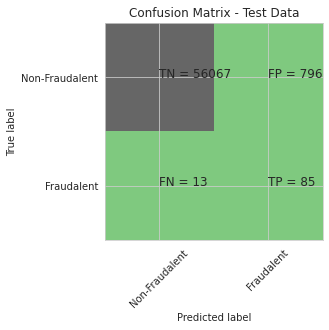

classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56863
           1       0.10      0.87      0.17        98

    accuracy                           0.99     56961
   macro avg       0.55      0.93      0.58     56961
weighted avg       1.00      0.99      0.99     56961

Accuarcy of Logistic model with l1 regularisation : 0.9982795245869981
Confusion Matrix


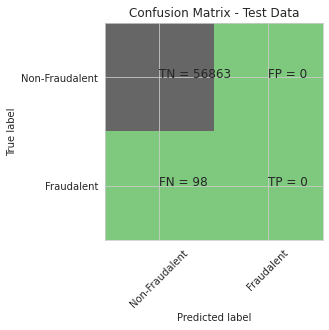

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56961
   macro avg       0.50      0.50      0.50     56961
weighted avg       1.00      1.00      1.00     56961

l2 roc_value: 0.980748393830212
l2 threshold: 0.33057296191273045
ROC for the test dataset 98.1%


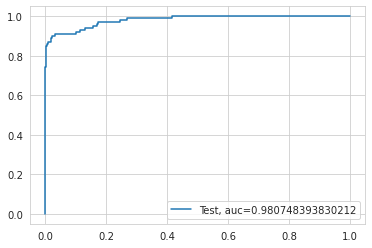

l1 roc_value: 0.5
l1 threshold: 1.5
ROC for the test dataset 50.0%


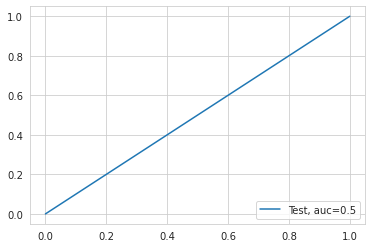

Time Taken by Model: --- 318.08953976631165 seconds ---
--------------------------------------------------------------------------------


In [99]:
#Run Logistic Regression with L1 And L2 Regularisation
Data_Imbalance_Handiling	 = "Random Oversampling with StratifiedKFold CV "
print("Logistic Regression with L1 And L2 Regularisation")
start_time = time.time()
df_Results = buildAndRunLogisticModels(df_Results , Data_Imbalance_Handiling , X_over, y_over, X_test, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )

### Similarly explore other algorithms on balanced dataset by building models like:
- KNN
- SVM
- Decision Tree
- Random Forest
- XGBoost

KNN Model
model score
0.9980688541282632
Confusion Matrix


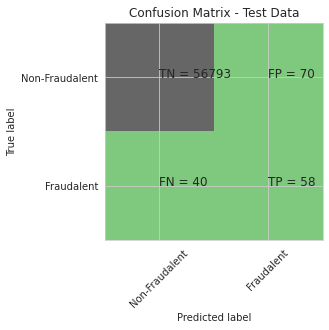

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.45      0.59      0.51        98

    accuracy                           1.00     56961
   macro avg       0.73      0.80      0.76     56961
weighted avg       1.00      1.00      1.00     56961

KNN roc_value: 0.805604465728046
KNN threshold: 0.2
ROC for the test dataset 80.6%


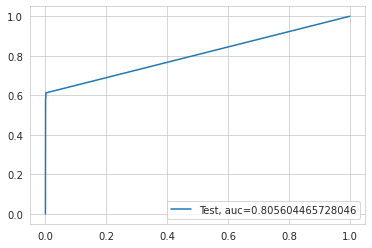

Time Taken by Model: --- 158.92348289489746 seconds ---
--------------------------------------------------------------------------------


In [100]:
#Run KNN Model
print("KNN Model")
start_time = time.time()
df_Results = buildAndRunKNNModels(df_Results , Data_Imbalance_Handiling,X_over, y_over, X_test, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )

Decision Tree Models with  'gini' & 'entropy' criteria
gini score: 0.9991397622934991
Confusion Matrix


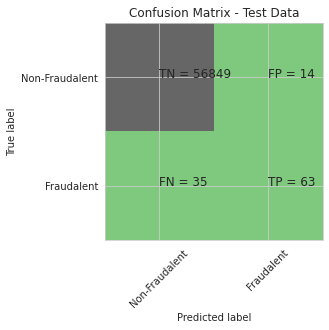

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.82      0.64      0.72        98

    accuracy                           1.00     56961
   macro avg       0.91      0.82      0.86     56961
weighted avg       1.00      1.00      1.00     56961

gini tree_roc_value: 0.8213054685321362
Tree threshold: 1.0
ROC for the test dataset 82.1%


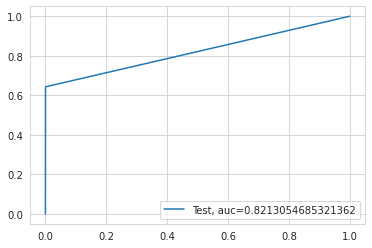

entropy score: 0.9992450975228665
Confusion Matrix


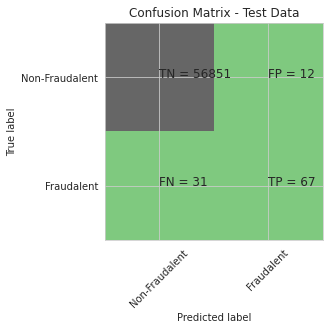

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.85      0.68      0.76        98

    accuracy                           1.00     56961
   macro avg       0.92      0.84      0.88     56961
weighted avg       1.00      1.00      1.00     56961

entropy tree_roc_value: 0.8417312179255044
Tree threshold: 1.0
ROC for the test dataset 84.2%


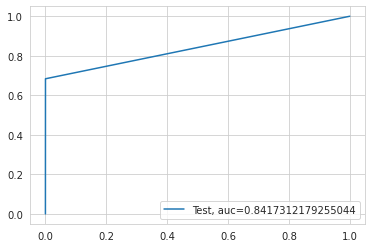

Time Taken by Model: --- 20.715247869491577 seconds ---
--------------------------------------------------------------------------------


In [101]:
#Run Decision Tree Models with  'gini' & 'entropy' criteria
print("Decision Tree Models with  'gini' & 'entropy' criteria")
start_time = time.time()
df_Results = buildAndRunTreeModels(df_Results , Data_Imbalance_Handiling,X_over, y_over, X_test, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )

Random Forest Model
Model Accuracy: 0.999490879724724
Confusion Matrix


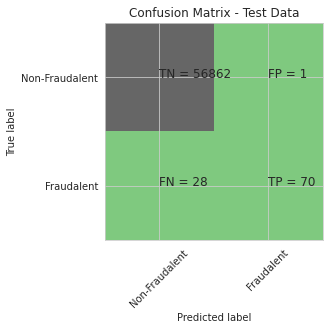

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.99      0.71      0.83        98

    accuracy                           1.00     56961
   macro avg       0.99      0.86      0.91     56961
weighted avg       1.00      1.00      1.00     56961

Random Forest roc_value: 0.9410514781858438
Random Forest threshold: 0.02
ROC for the test dataset 94.1%


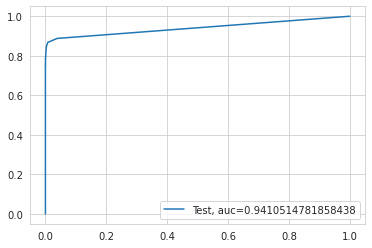

Time Taken by Model: --- 138.98803186416626 seconds ---
--------------------------------------------------------------------------------


In [102]:
#Run Random Forest Model
print("Random Forest Model")
start_time = time.time()
df_Results = buildAndRunRandomForestModels(df_Results , Data_Imbalance_Handiling,X_over, y_over, X_test, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )

XGBoost Model
[13:33:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model Accuracy: 0.999490879724724
Confusion Matrix


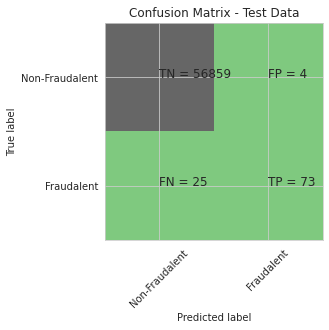

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.95      0.74      0.83        98

    accuracy                           1.00     56961
   macro avg       0.97      0.87      0.92     56961
weighted avg       1.00      1.00      1.00     56961

XGboost roc_value: 0.9817972807539209
XGBoost threshold: 0.00010483648657100275
ROC for the test dataset 98.2%


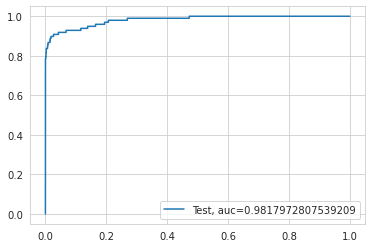

Time Taken by Model: --- 28.875630855560303 seconds ---
--------------------------------------------------------------------------------


In [103]:
#Run XGBoost Model
print("XGBoost Model")
start_time = time.time()
df_Results = buildAndRunXGBoostModels(df_Results , Data_Imbalance_Handiling,X_over, y_over, X_test, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )

In [104]:
df_Results

,Data_Imbalance_Handiling,Model,Accuracy,roc_value,threshold
0,Power Transformer,Logistic Regression with L2 Regularisation,0.999087,0.981117,0.003049
1,Power Transformer,Logistic Regression with L1 Regularisation,0.999140,0.982981,0.006689
2,Power Transformer,KNN,0.999526,0.928463,0.200000
3,Power Transformer,Tree Model with gini criteria,0.999070,0.897669,1.000000
4,Power Transformer,Tree Model with entropy criteria,0.999157,0.867153,1.000000
5,Power Transformer,Random Forest,0.999561,0.962756,0.010000
6,Power Transformer,XGBoost,0.999614,0.982308,0.000071
7,Power Transformer,SVM,0.998754,0.856414,0.000212
8,RepeatedKFold Cross Validation,Logistic Regression with L2 Regularisation,0.999070,0.984917,0.001333
9,RepeatedKFold Cross Validation,Logistic Regression with L1 Regularisation,0.999087,0.846377,0.062460


### Observations:
- XG Boost provides better result with Random Oversampling.

### Print the class distribution after applying SMOTE 

InvalidIndexError: (slice(None, 394, None), 0)

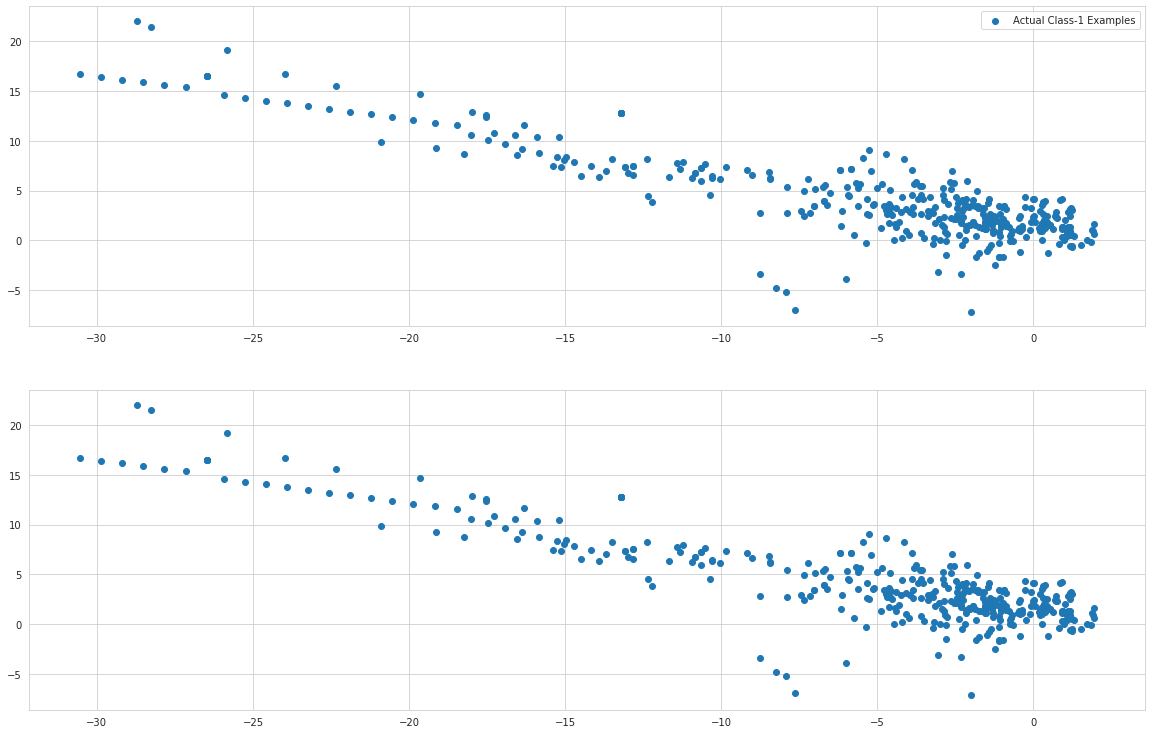

In [112]:
import warnings
warnings.filterwarnings("ignore")

from imblearn import over_sampling
SMOTE = over_sampling.SMOTE(random_state=0)

X_train_Smote, y_train_Smote= SMOTE.fit_sample(X_train, y_train) 

#Create dataframe
#X_train_Smote = pd.DataFrame(data=X_train_Smote,   columns=cols)
# Artificial minority samples and corresponding minority labels from SMOTE are appended
# below X_train and y_train respectively
# So to exclusively get the artificial minority samples from SMOTE, we do
X_train_smote_1 = X_train_Smote[X_train.shape[0]:]

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]


plt.rcParams['figure.figsize'] = [20, 20]
fig = plt.figure()

plt.subplot(3, 1, 1)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 2)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_smote_1[:X_train_1.shape[0], 0], X_train_smote_1[:X_train_1.shape[0], 1],
            label='Artificial SMOTE Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 3)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], 0], X_train_0[:X_train_1.shape[0], 1], label='Actual Class-0 Examples')
plt.legend()

#Create dataframe
X_train_Smote = pd.DataFrame(data=X_train_Smote,   columns=cols)

In [113]:
from sklearn.model_selection import StratifiedKFold
from imblearn import over_sampling

skf = StratifiedKFold(n_splits=5, random_state=None)

for fold, (train_index, test_index) in enumerate(skf.split(X,y), 1):
    X_train = X.loc[train_index]
    y_train = y.loc[train_index] 
    X_test = X.loc[test_index]
    y_test = y.loc[test_index]  
    SMOTE = over_sampling.SMOTE(random_state=0)
    X_train_Smote, y_train_Smote= SMOTE.fit_sample(X_train, y_train)
  
#Create Dataframe for X_over
X_train_Smote = pd.DataFrame(data=X_train_Smote,   columns=cols)

In [ ]:
#Run Logistic Regression with L1 And L2 Regularisation
Data_Imbalance_Handiling	 = "SMOTE Oversampling with StratifiedKFold CV "
print("Logistic Regression with L1 And L2 Regularisation")
start_time = time.time()
df_Results = buildAndRunLogisticModels(df_Results, Data_Imbalance_Handiling, X_train_Smote, y_train_Smote , X_test, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )

Logistic Regression with L1 And L2 Regularisation


### Similarly explore other algorithms on balanced dataset by building models like:
- KNN
- Decision Tree
- Random Forest
- XGBoost

In [ ]:
#Run KNN Model
print("KNN Model")
start_time = time.time()
df_Results = buildAndRunKNNModels(df_Results, Data_Imbalance_Handiling, X_train_Smote, y_train_Smote , X_test, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )

In [ ]:
#Run Decision Tree Models with  'gini' & 'entropy' criteria
print("Decision Tree Models with  'gini' & 'entropy' criteria")
start_time = time.time()
df_Results = buildAndRunTreeModels(df_Results, Data_Imbalance_Handiling, X_train_Smote, y_train_Smote , X_test, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )

In [ ]:
#Run Random Forest Model
print("Random Forest Model")
start_time = time.time()
df_Results = buildAndRunRandomForestModels(df_Results, Data_Imbalance_Handiling, X_train_Smote, y_train_Smote , X_test, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )

In [ ]:
#Run XGBoost Model
print("XGBoost Model")
start_time = time.time()
df_Results = buildAndRunXGBoostModels(df_Results, Data_Imbalance_Handiling, X_train_Smote, y_train_Smote , X_test, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )

In [ ]:
df_Results

## Results for SMOTE Oversampling:
- XGBoost provides better results for SMOTE oversampling technique

##### Build models on other algorithms to see the better performing on SMOTE

### Print the class distribution after applying ADASYN

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from imblearn import over_sampling

ada = over_sampling.ADASYN(random_state=0)
X_train_adasyn, y_train_adasyn = ada.fit_resample(X_train, y_train)
# Artificial minority samples and corresponding minority labels from ADASYN are appended
# below X_train and y_train respectively
# So to exclusively get the artificial minority samples from ADASYN, we do
X_train_adasyn_1 = X_train_adasyn[X_train.shape[0]:]

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]



import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]
fig = plt.figure()

plt.subplot(3, 1, 1)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 2)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_adasyn_1[:X_train_1.shape[0], 0], X_train_adasyn_1[:X_train_1.shape[0], 1],
            label='Artificial ADASYN Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 3)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], 0], X_train_0[:X_train_1.shape[0], 1], label='Actual Class-0 Examples')
plt.legend()

In [ ]:
#perform cross validation & then balance classes on X_train_cv & y_train_cv using ADASYN

#perform hyperparameter tuning

#print the evaluation result by choosing a evaluation metric

#print the optimum value of hyperparameters


##### Build models on other algorithms to see the better performing on ADASYN

### Select the oversampling method which shows the best result on a model
- Apply the best hyperparameter on the model
- Predict on the test dataset

In [ ]:
# perform the best oversampling method on X_train & y_train

clf = ___  #initialise the model with optimum hyperparameters
clf.fit( ) # fit on the balanced dataset
print() --> #print the evaluation score on the X_test by choosing the best evaluation metric

### Print the important features of the best model to understand the dataset

In [ ]:
var_imp = []
for i in clf.feature_importances_:
    var_imp.append(i)
print('Top var =', var_imp.index(np.sort(clf.feature_importances_)[-1])+1)
print('2nd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-2])+1)
print('3rd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-3])+1)

# Variable on Index-13 and Index-9 seems to be the top 2 variables
top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-1])
second_top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-2])

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]

np.random.shuffle(X_train_0)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]

plt.scatter(X_train_1[:, top_var_index], X_train_1[:, second_top_var_index], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], top_var_index], X_train_0[:X_train_1.shape[0], second_top_var_index],
            label='Actual Class-0 Examples')
plt.legend()

In [ ]:
#### Print the FPR,TPR & select the best threshold from the roc curve

In [ ]:
print('Train auc =', metrics.roc_auc_score(_________)
fpr, tpr, thresholds = metrics.roc_curve(_________)
threshold = thresholds[np.argmax(tpr-fpr)]
print(threshold)